In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [3]:
image_dir = Path('/kaggle/input/diabetic-retinopathy-dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

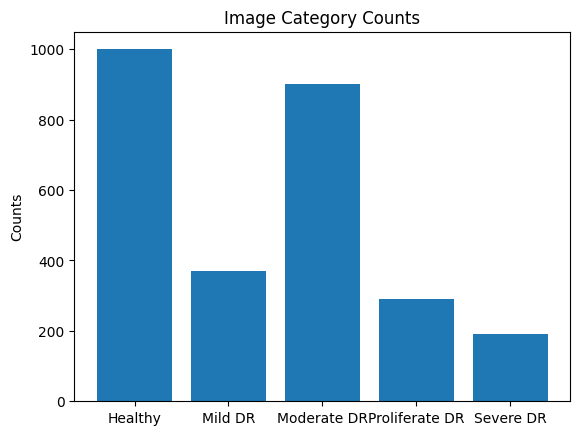

In [4]:
import matplotlib.pyplot as plt

# Sample image categories and counts
categories = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
counts = [1000, 370, 900, 290, 190]
# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis labels as the image categories
x = np.arange(len(categories))
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Plot the counts as bars
ax.bar(x, counts)

# Set the y-axis label
ax.set_ylabel('Counts')

# Set the title of the bar graph
ax.set_title('Image Category Counts')

# Show the plot
plt.show()

In [5]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()

Filepath           Label
0  /kaggle/input/diabetic-retinopathy-dataset/Hea...         Healthy
1  /kaggle/input/diabetic-retinopathy-dataset/Mil...         Mild DR
2  /kaggle/input/diabetic-retinopathy-dataset/Mod...     Moderate DR
3  /kaggle/input/diabetic-retinopathy-dataset/Pro...  Proliferate DR
4  /kaggle/input/diabetic-retinopathy-dataset/Hea...         Healthy

In [6]:
import keras.backend as K
gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

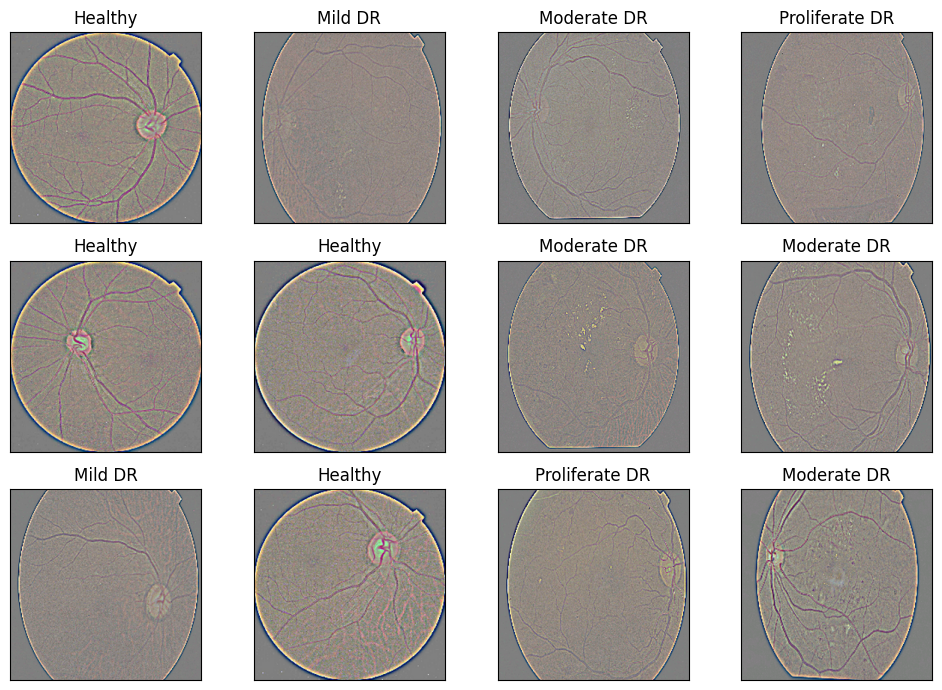

In [7]:
#display images with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

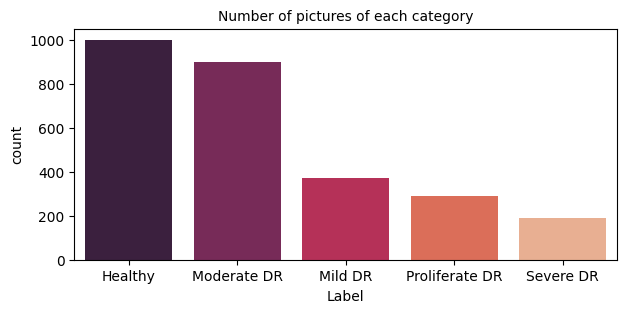

In [8]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(7,3))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 10)
plt.show()

In [9]:
n_fold=5
kf = KFold(n_splits=n_fold, shuffle=True)

In [10]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [11]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [12]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt



In [14]:
# Load and preprocess the data
train_generator, test_generator, train_images, val_images, test_images = create_gen()

Found 2228 validated image filenames belonging to 5 classes.
Found 247 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


In [15]:
# Define Mixup augmentation function
def mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    lam = tf.random.uniform([batch_size], 0, 1)
    lam = tf.maximum(lam, 1 - lam)
    
    mix_images = lam[:, tf.newaxis, tf.newaxis, tf.newaxis] * images + (1 - lam[:, tf.newaxis, tf.newaxis, tf.newaxis]) * tf.reverse(images, axis=[0])
    mix_labels = lam[:, tf.newaxis] * labels + (1 - lam[:, tf.newaxis]) * labels[::-1]
    return mix_images, mix_labels

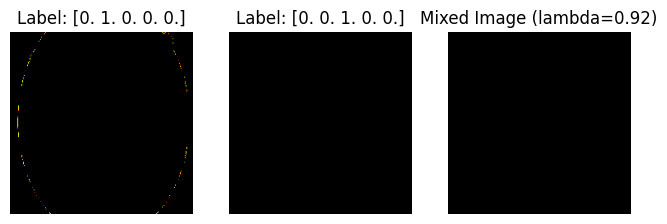

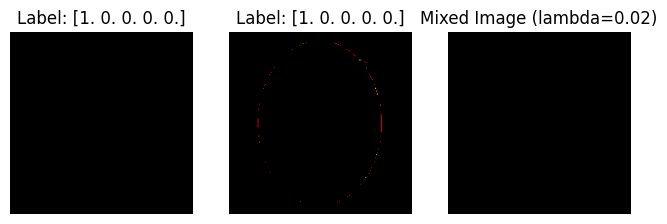

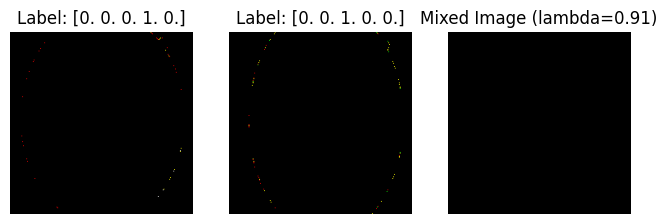

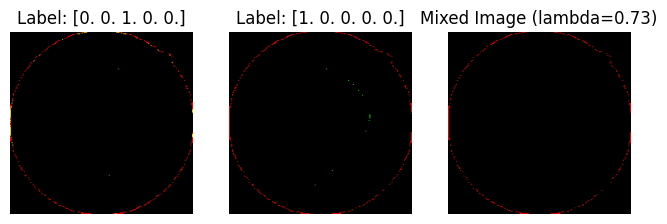

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Create a function to display mixed images
def display_mixup_images(generator, num_images=4):
    for _ in range(num_images):
        # Generate a batch of mixed images and labels
        x, y = next(generator)

        # Take the first two images from the batch
        image1, image2 = x[:2]
        label1, label2 = y[:2]

        # Calculate the Mixup weight (lambda)
        lam = np.random.beta(0.2, 0.2)  # You can adjust these parameters

        # Mix the two images
        mixed_image = (lam * image1) + ((1 - lam) * image2)

        # Display the mixed image
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 3, 1)
        plt.title(f"Label: {label1}")
        plt.imshow(image1.astype(np.uint8))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title(f"Label: {label2}")
        plt.imshow(image2.astype(np.uint8))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f"Mixed Image (lambda={lam:.2f})")
        plt.imshow(mixed_image.astype(np.uint8))
        plt.axis('off')

        plt.show()

# Use the function to display mixed images
display_mixup_images(train_images)


In [17]:
# Define evaluation functions
def evaluate_model(model, test_images):
    y_true = test_images.classes
    y_pred = model.predict(test_images)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=categories))
    
    # Compute ROC curve and AUC for each class
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(categories)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(categories)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{categories[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    
    plt.tight_layout()
    plt.show()
    
    
    # CONFUSION
    cm = confusion_matrix(y_true, y_pred_classes)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



In [18]:
def create_gen(train_df, val_df):
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,  # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,  # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    return train_generator, test_generator, train_images, val_images


In [24]:
# Create and preprocess the data generators for this fold
train_generator_fold, _, train_images_fold, val_images_fold = create_gen(train_df_fold, val_df_fold)

Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.


In [20]:
from sklearn.model_selection import StratifiedKFold

In [21]:
k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

Fold 1/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
31/31 - 55s - loss: 0.9644 - accuracy: 0.6399 - val_loss: 0.7378 - val_accuracy: 0.7061 - 55s/epoch - 2s/step
Epoch 2/50
31/31 - 23s - loss: 0.7023 - accuracy: 0.7237 - val_loss: 0.6408 - val_accuracy: 0.7505 - 23s/epoch - 743ms/step
Epoch 3/50
31/31 - 32s - loss: 0.6321 - accuracy: 0.7490 - val_loss: 0.6330 - val_accuracy: 0.7540 - 32s/epoch - 1s/step
Epoch 4/50
31/31 - 23s - loss: 0.6142 - accuracy: 0.7707 - val_loss: 0.5677 - val_accuracy: 0.7763 - 23s/epoch - 757ms/step
Epoch 5/50
31/31 - 24s - loss: 0.5916 - accuracy: 0.7657 - val_loss: 0.5457 - val_accuracy: 0.7929 - 24s/epoch - 763ms/step
Epoch 6/50
31/31 - 23s - loss: 0.5783 - accuracy: 0.7727 - val_loss: 0.5487 - val_accuracy: 0.7737 - 23s/epoch - 740ms/step
Epoch 7/50
31/31 - 23s - loss: 0.5335 - accuracy: 0.7909 - val_loss:

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


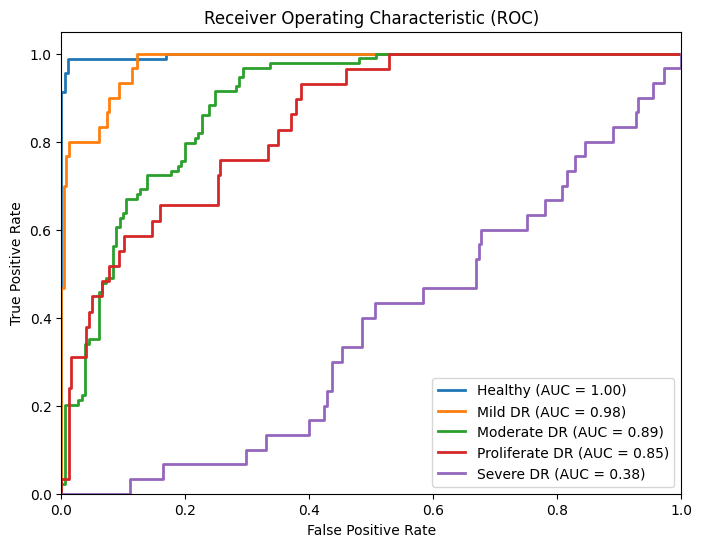

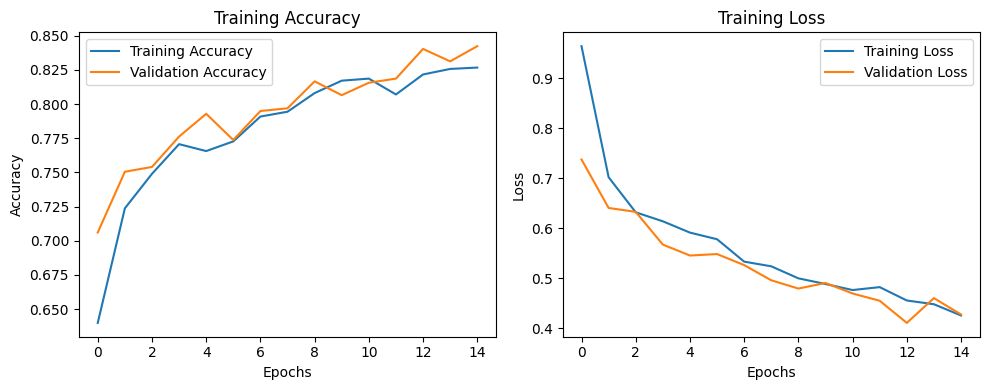

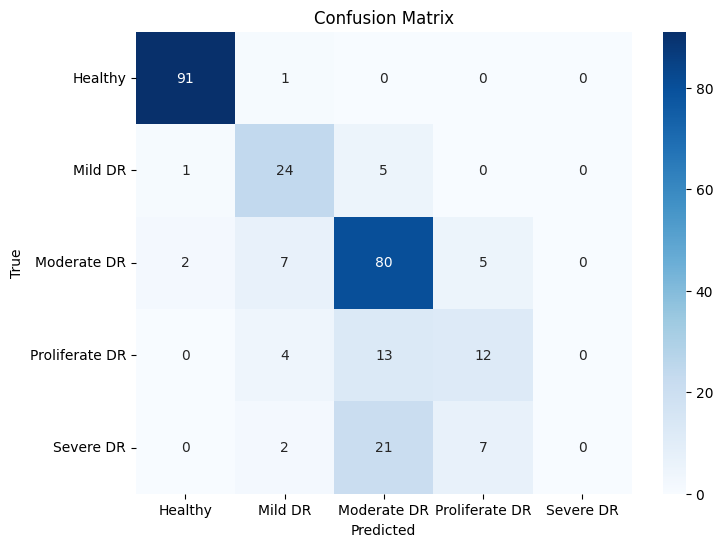

Fold 2/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 33s - loss: 0.9380 - accuracy: 0.6455 - val_loss: 0.7073 - val_accuracy: 0.7298 - 33s/epoch - 1s/step
Epoch 2/50
31/31 - 23s - loss: 0.6757 - accuracy: 0.7475 - val_loss: 0.6457 - val_accuracy: 0.7399 - 23s/epoch - 732ms/step
Epoch 3/50
31/31 - 23s - loss: 0.6152 - accuracy: 0.7662 - val_loss: 0.6186 - val_accuracy: 0.7500 - 23s/epoch - 745ms/step
Epoch 4/50
31/31 - 32s - loss: 0.5964 - accuracy: 0.7662 - val_loss: 0.5780 - val_accuracy: 0.7652 - 32s/epoch - 1s/step
Epoch 5/50
31/31 - 23s - loss: 0.5717 - accuracy: 0.7732 - val_loss: 0.5656 - val_accuracy: 0.7848 - 23s/epoch - 743ms/step
Epoch 6/50
31/31 - 32s - loss: 0.5622 - accuracy: 0.7758 - val_loss: 0.5600 - val_accuracy: 0.7874 - 32s/epoch - 1s/step
Epoch 7/50
31/31 - 22s - loss: 0.5540 - accuracy: 0.7778 - val_loss: 0.5668 - val_accuracy: 0.7641 - 22s/epoch - 726ms/step
Epoch 8/50
3

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


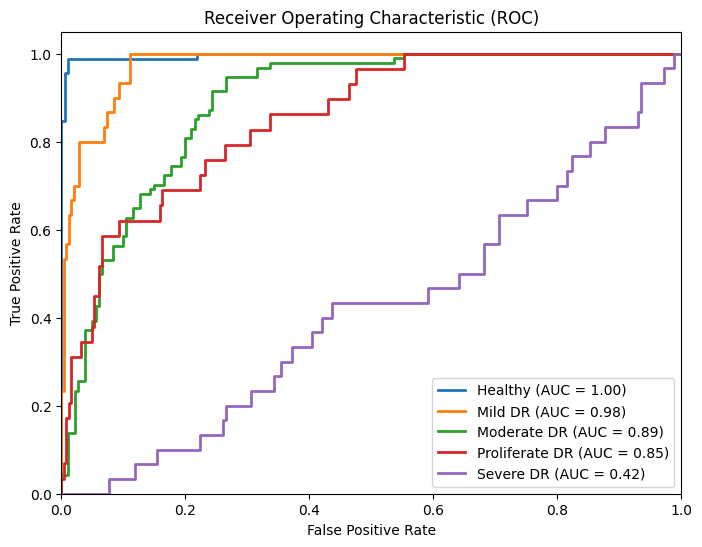

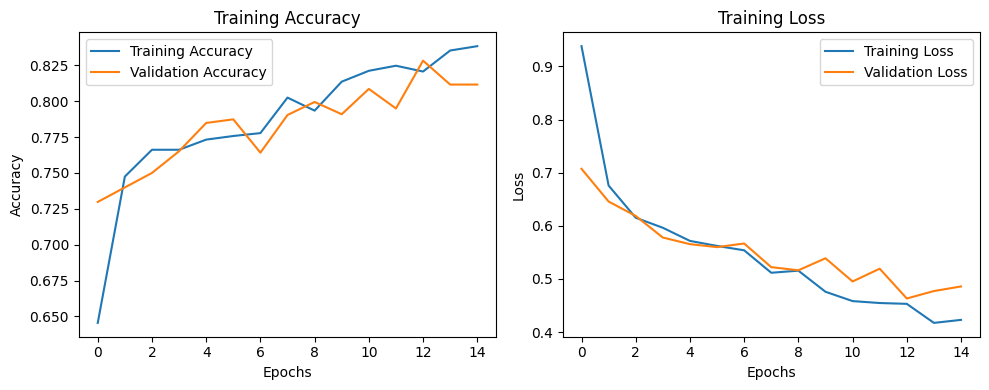

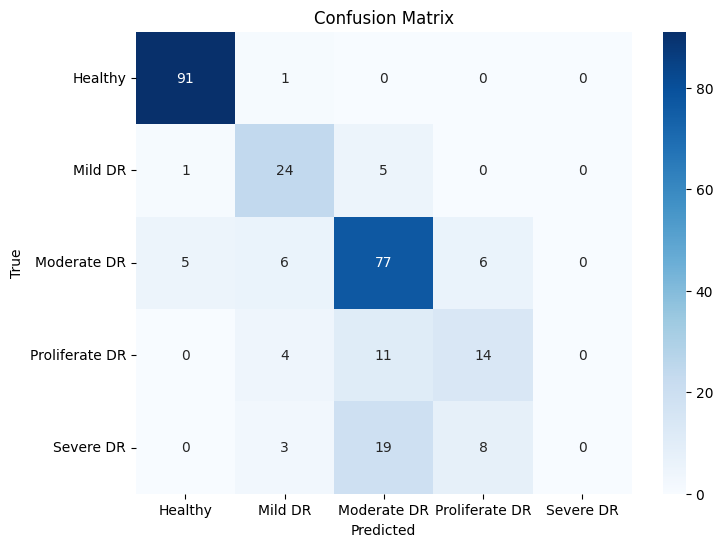

Fold 3/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 31s - loss: 0.8821 - accuracy: 0.6747 - val_loss: 0.7204 - val_accuracy: 0.7172 - 31s/epoch - 1s/step
Epoch 2/50
31/31 - 22s - loss: 0.6773 - accuracy: 0.7409 - val_loss: 0.7231 - val_accuracy: 0.7364 - 22s/epoch - 723ms/step
Epoch 3/50
31/31 - 22s - loss: 0.6178 - accuracy: 0.7515 - val_loss: 0.5982 - val_accuracy: 0.7737 - 22s/epoch - 724ms/step
Epoch 4/50
31/31 - 22s - loss: 0.6094 - accuracy: 0.7667 - val_loss: 0.5999 - val_accuracy: 0.7606 - 22s/epoch - 710ms/step
Epoch 5/50
31/31 - 23s - loss: 0.5760 - accuracy: 0.7773 - val_loss: 0.6242 - val_accuracy: 0.7657 - 23s/epoch - 735ms/step
5/5 [==============================] - 3s 307ms/step
Classification Report:
                precision    recall  f1-score   support

       Healthy       0.93      0.97      0.95        92
       Mild DR       0.51      0.80      0.62        30
   Modera

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


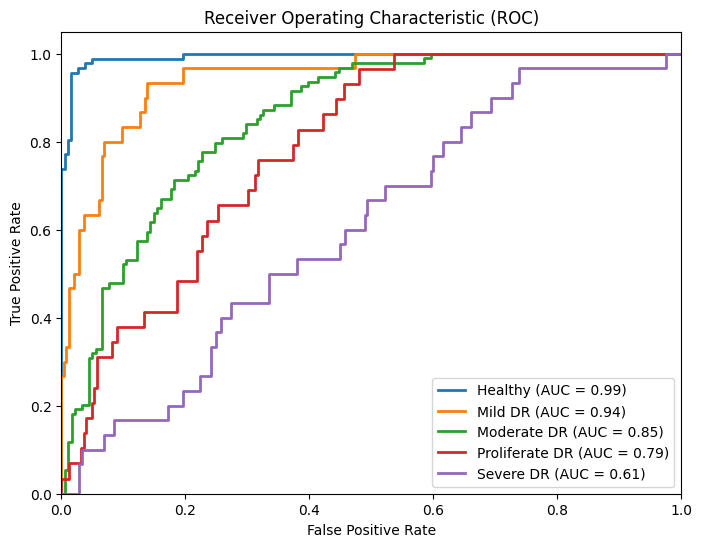

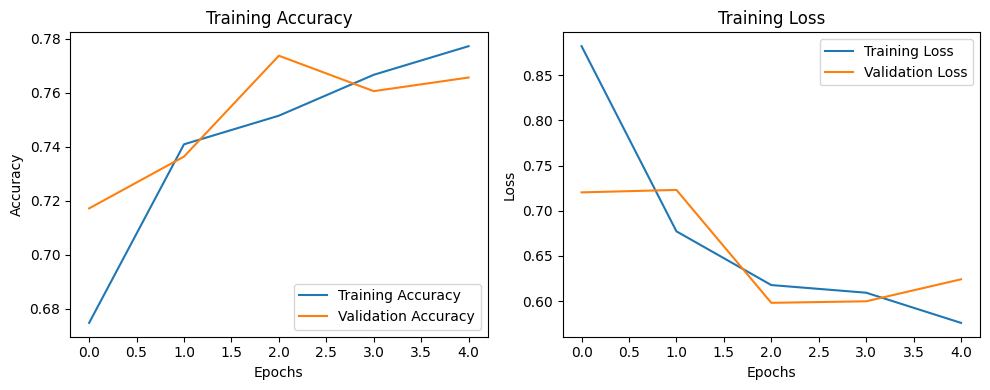

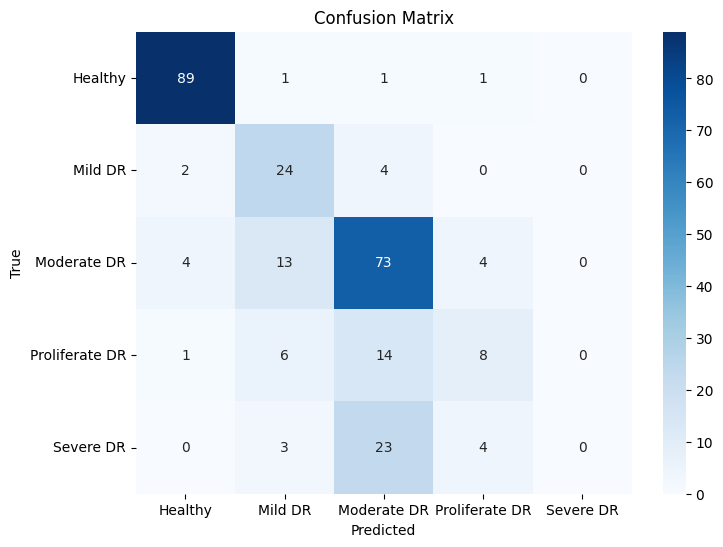

Fold 4/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 31s - loss: 0.9222 - accuracy: 0.6369 - val_loss: 0.7426 - val_accuracy: 0.7359 - 31s/epoch - 997ms/step
Epoch 2/50
31/31 - 22s - loss: 0.6814 - accuracy: 0.7389 - val_loss: 0.6452 - val_accuracy: 0.7596 - 22s/epoch - 722ms/step
Epoch 3/50
31/31 - 23s - loss: 0.6242 - accuracy: 0.7621 - val_loss: 0.6277 - val_accuracy: 0.7510 - 23s/epoch - 740ms/step
Epoch 4/50
31/31 - 23s - loss: 0.6108 - accuracy: 0.7657 - val_loss: 0.5803 - val_accuracy: 0.7753 - 23s/epoch - 743ms/step
Epoch 5/50
31/31 - 22s - loss: 0.5692 - accuracy: 0.7763 - val_loss: 0.5569 - val_accuracy: 0.7854 - 22s/epoch - 714ms/step
Epoch 6/50
31/31 - 23s - loss: 0.5402 - accuracy: 0.7944 - val_loss: 0.5572 - val_accuracy: 0.7788 - 23s/epoch - 735ms/step
Epoch 7/50
31/31 - 22s - loss: 0.5355 - accuracy: 0.7879 - val_loss: 0.6095 - val_accuracy: 0.7359 - 22s/epoch - 721ms/step
5/5

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


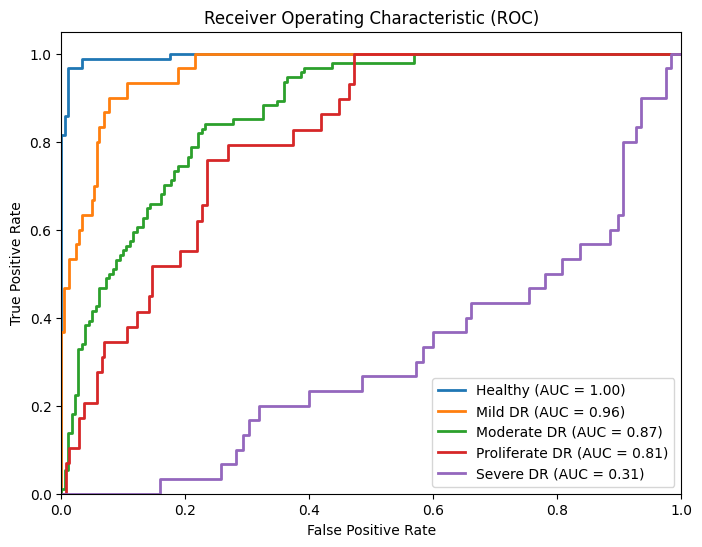

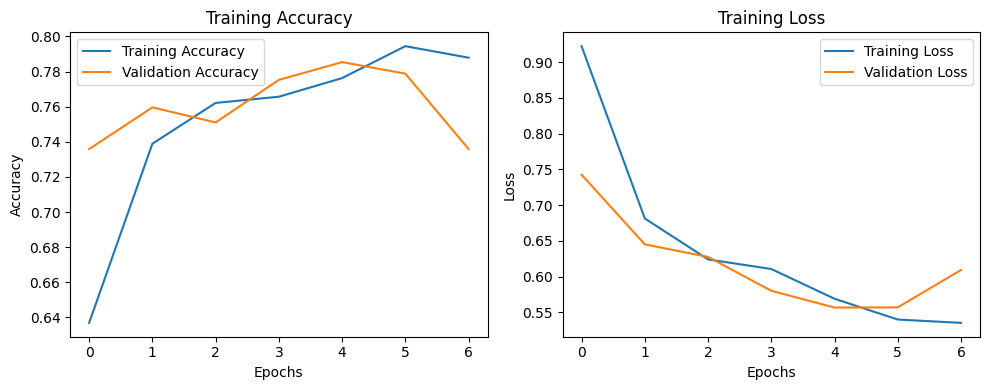

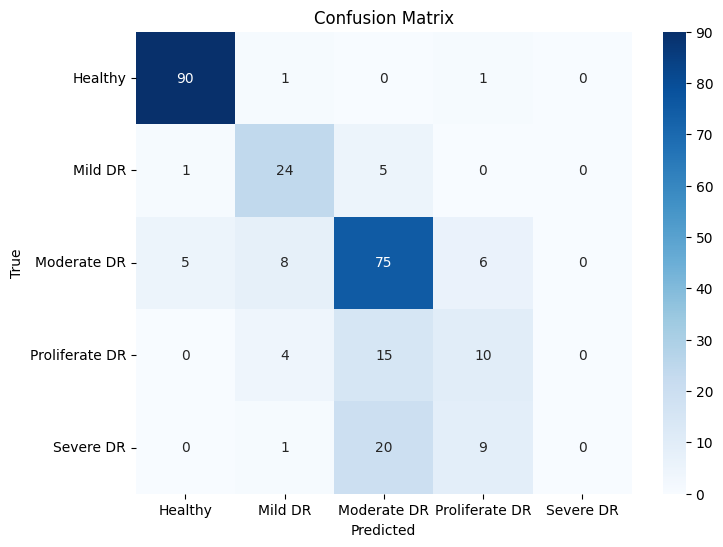

Fold 5/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 32s - loss: 0.9417 - accuracy: 0.6485 - val_loss: 0.7368 - val_accuracy: 0.7283 - 32s/epoch - 1s/step
Epoch 2/50
31/31 - 23s - loss: 0.6914 - accuracy: 0.7303 - val_loss: 0.6483 - val_accuracy: 0.7556 - 23s/epoch - 737ms/step
Epoch 3/50
31/31 - 23s - loss: 0.6350 - accuracy: 0.7601 - val_loss: 0.6048 - val_accuracy: 0.7540 - 23s/epoch - 739ms/step
Epoch 4/50
31/31 - 22s - loss: 0.6030 - accuracy: 0.7606 - val_loss: 0.6411 - val_accuracy: 0.7283 - 22s/epoch - 718ms/step
Epoch 5/50
31/31 - 23s - loss: 0.5970 - accuracy: 0.7551 - val_loss: 0.5870 - val_accuracy: 0.7576 - 23s/epoch - 730ms/step
Epoch 6/50
31/31 - 23s - loss: 0.5562 - accuracy: 0.7823 - val_loss: 0.5704 - val_accuracy: 0.7758 - 23s/epoch - 744ms/step
Epoch 7/50
31/31 - 23s - loss: 0.5300 - accuracy: 0.7899 - val_loss: 0.5547 - val_accuracy: 0.7833 - 23s/epoch - 735ms/step
Epoch 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


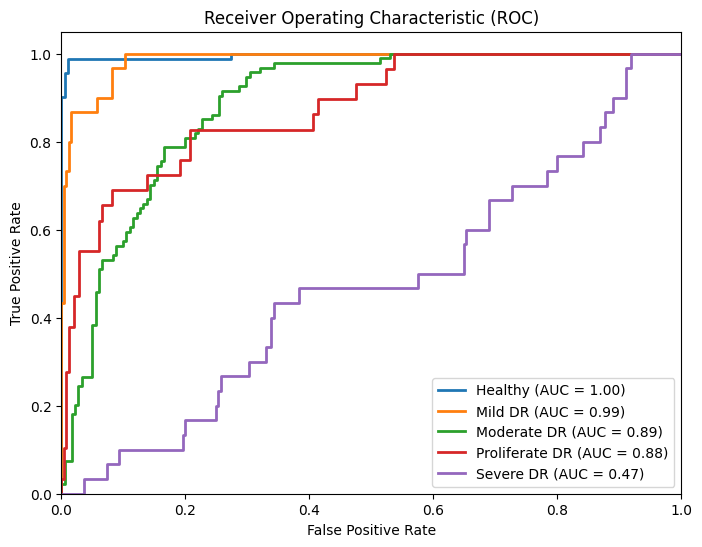

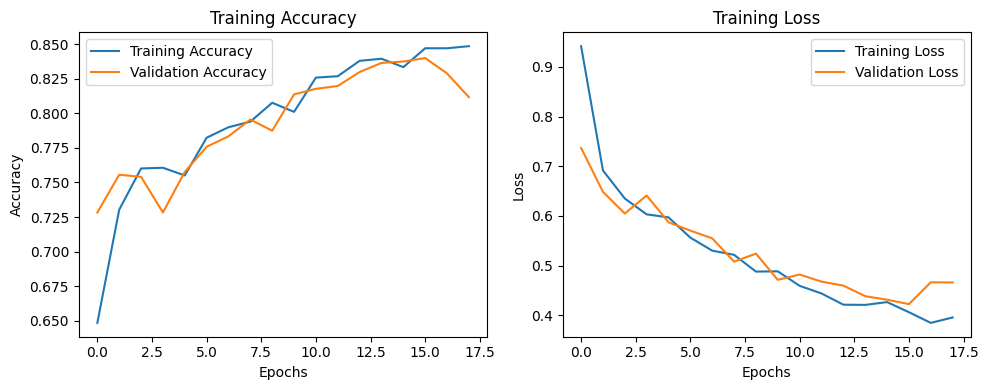

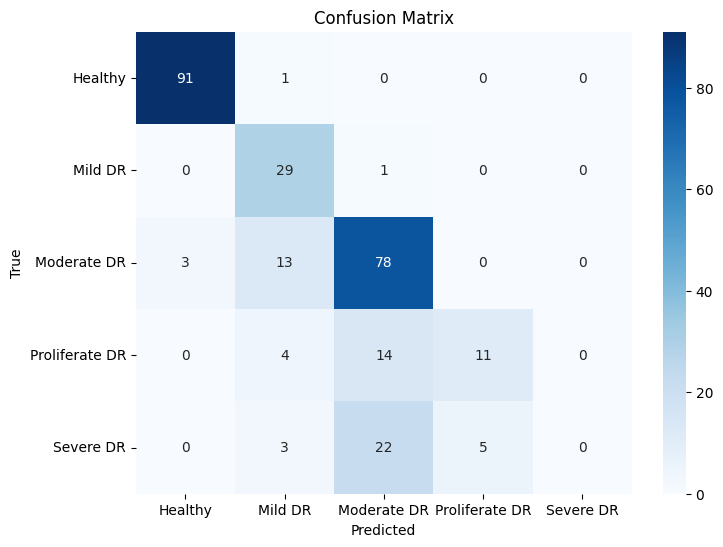

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import DenseNet121

# Initialize a list to store the results for each fold
fold_results = []

# Initialize variables to keep track of the best model
best_model = None
best_val_loss = float('inf')  # Set to positive infinity initially

# Loop over the folds
for fold, (train_index, val_index) in enumerate(skf.split(filepaths, labels)):
    print(f"Fold {fold + 1}/{k}")
    
    train_filepaths = filepaths[train_index]
    val_filepaths = filepaths[val_index]
    train_labels = labels[train_index]
    val_labels = labels[val_index]
    
    train_df_fold = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
    val_df_fold = pd.DataFrame({'Filepath': val_filepaths, 'Label': val_labels})
    
    # Create and preprocess the data generators for this fold
    train_generator_fold, _, val_images_fold, test_images_fold = create_gen(train_df_fold, val_df_fold)

    
    # Create the model for this fold
    model = get_model(DenseNet121)  # You can change the model architecture here
    
    # Train the model for a fixed number of epochs
    history = model.fit(
        train_images_fold,
        epochs=50,
        validation_data=val_images_fold,
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )
    
    # Evaluate the model on the test data
    evaluate_model(model, test_images)
    
    # Check if the current model's validation loss is better than the best model so far
    if history.history['val_loss'][-1] < best_val_loss:
        best_model = model
        best_val_loss = history.history['val_loss'][-1]
    
    # Append the evaluation results to the fold_results list
    fold_results.append(history)

# Save the best model
best_model.save("best_model_DenseNet121.h5")


In [27]:
#model.evaluate(test_images)

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

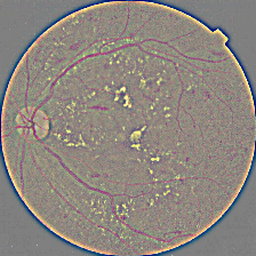

In [50]:
model_builder = keras.applications.DenseNet121
img_size = (224, 224)
preprocess_input = keras.applications.densenet.preprocess_input
decode_predictions = keras.applications.densenet.decode_predictions

last_conv_layer_name = "conv5_block16_concat"

# The local path to our target image
img_path = "/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR/Proliferate DR_117.png"

display(Image(img_path))

In [51]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

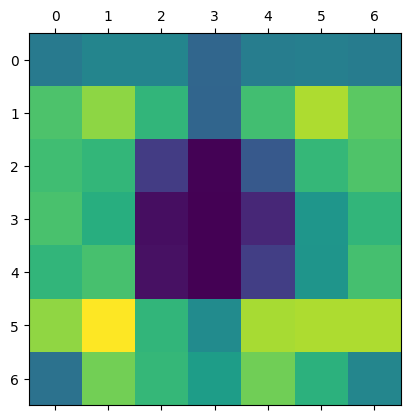

/tmp/ipykernel_28/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


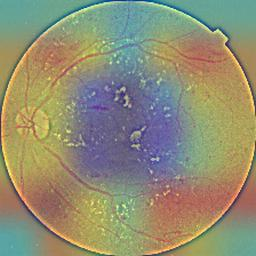

In [52]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model


model = get_model(model_builder)



# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare the image
img_array = keras.applications.xception.preprocess_input(get_img_array(img_path, size=img_size))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad-CAM result
save_and_display_gradcam(img_path, heatmap)


Fold 1/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
31/31 - 31s - loss: 1.0267 - accuracy: 0.6045 - val_loss: 0.9246 - val_accuracy: 0.6298 - 31s/epoch - 1s/step
Epoch 2/50
31/31 - 24s - loss: 0.9118 - accuracy: 0.6359 - val_loss: 0.9108 - val_accuracy: 0.6465 - 24s/epoch - 774ms/step
Epoch 3/50
31/31 - 23s - loss: 0.9058 - accuracy: 0.6308 - val_loss: 0.8851 - val_accuracy: 0.6470 - 23s/epoch - 752ms/step
Epoch 4/50
31/31 - 23s - loss: 0.8719 - accuracy: 0.6455 - val_loss: 0.8399 - val_accuracy: 0.6545 - 23s/epoch - 754ms/step
Epoch 5/50
31/31 - 23s - loss: 0.8534 - accuracy: 0.6545 - val_loss: 0.8807 - val_accuracy: 0.6662 - 23s/epoch - 740ms/step
Epoch 6/50
31/31 - 23s - loss: 0.8523 - accuracy: 0.6586 - val_loss: 0.8186 - val_accuracy: 0.6682 - 23s/epoch - 749ms/step
Epoch 7/50
31/31 - 23s - loss: 0.8440 - accuracy: 0.6646 - val_lo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


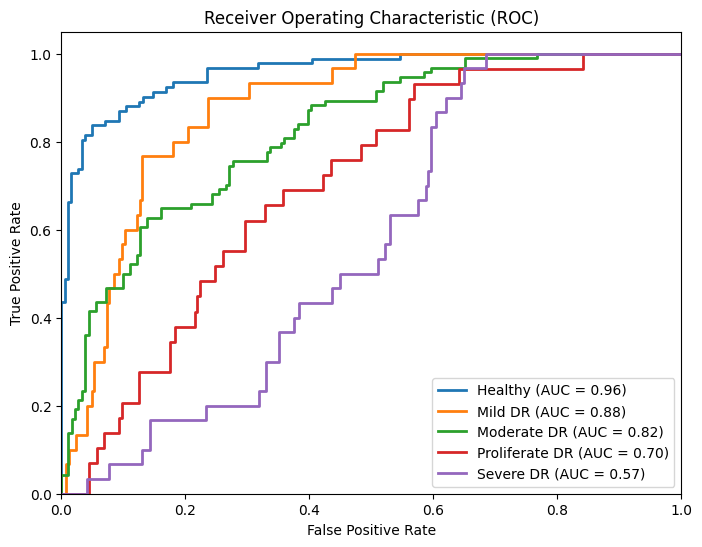

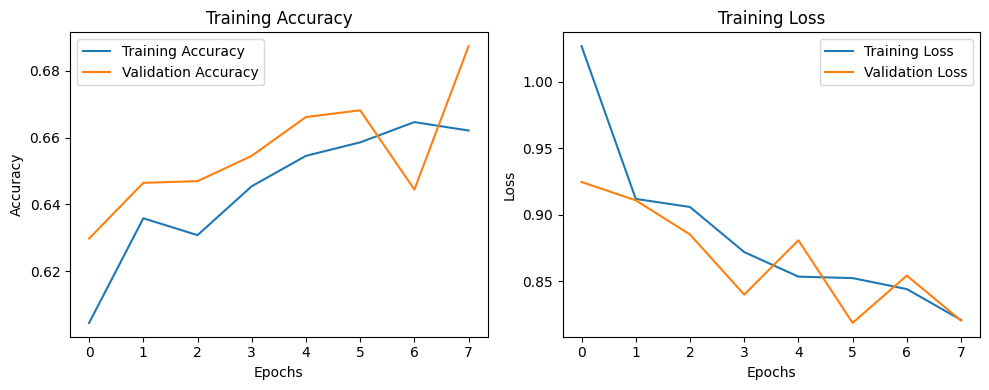

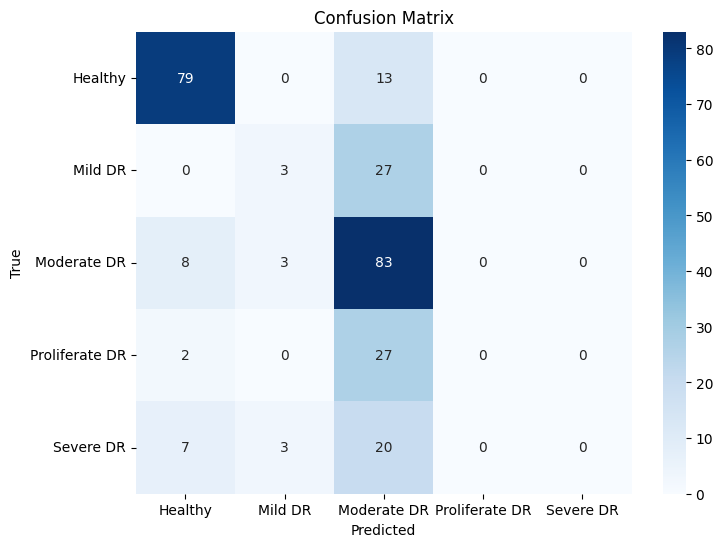

Fold 2/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 28s - loss: 1.1055 - accuracy: 0.5768 - val_loss: 0.9636 - val_accuracy: 0.6247 - 28s/epoch - 906ms/step
Epoch 2/50
31/31 - 23s - loss: 0.9412 - accuracy: 0.6187 - val_loss: 0.9211 - val_accuracy: 0.6343 - 23s/epoch - 743ms/step
Epoch 3/50
31/31 - 23s - loss: 0.8991 - accuracy: 0.6389 - val_loss: 0.9111 - val_accuracy: 0.6505 - 23s/epoch - 744ms/step
Epoch 4/50
31/31 - 23s - loss: 0.8933 - accuracy: 0.6419 - val_loss: 0.8762 - val_accuracy: 0.6505 - 23s/epoch - 745ms/step
Epoch 5/50
31/31 - 22s - loss: 0.8661 - accuracy: 0.6515 - val_loss: 0.8760 - val_accuracy: 0.6404 - 22s/epoch - 711ms/step
Epoch 6/50
31/31 - 23s - loss: 0.8620 - accuracy: 0.6475 - val_loss: 0.8524 - val_accuracy: 0.6611 - 23s/epoch - 733ms/step
Epoch 7/50
31/31 - 23s - loss: 0.8464 - accuracy: 0.6606 - val_loss: 0.8390 - val_accuracy: 0.6682 - 23s/epoch - 751ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


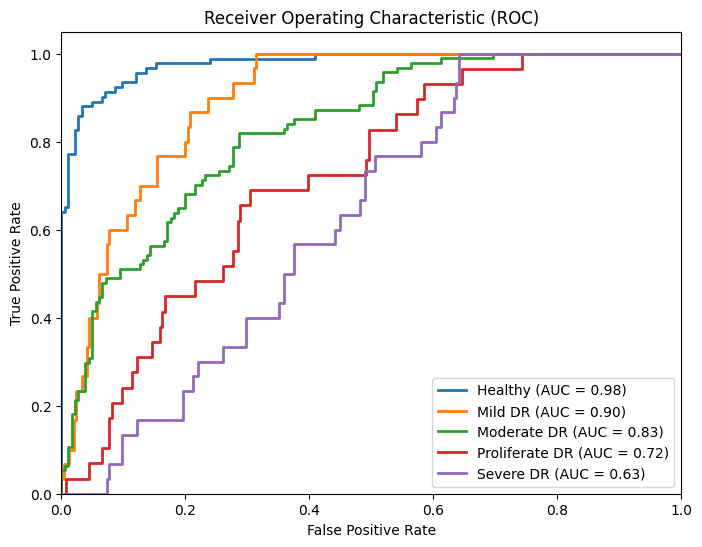

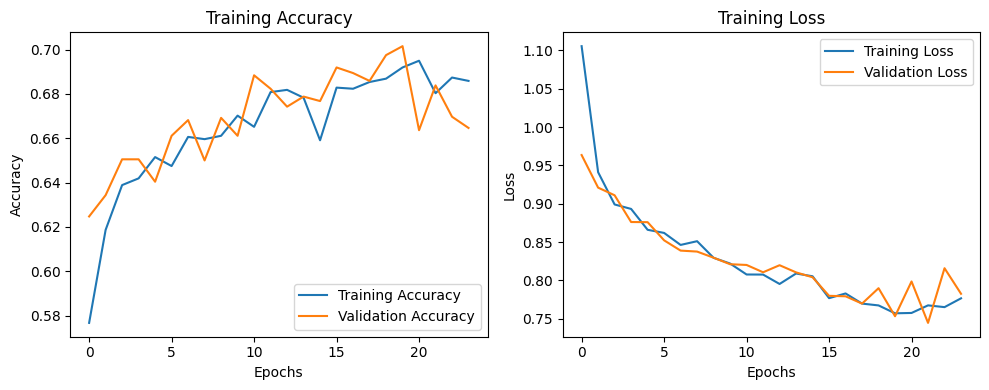

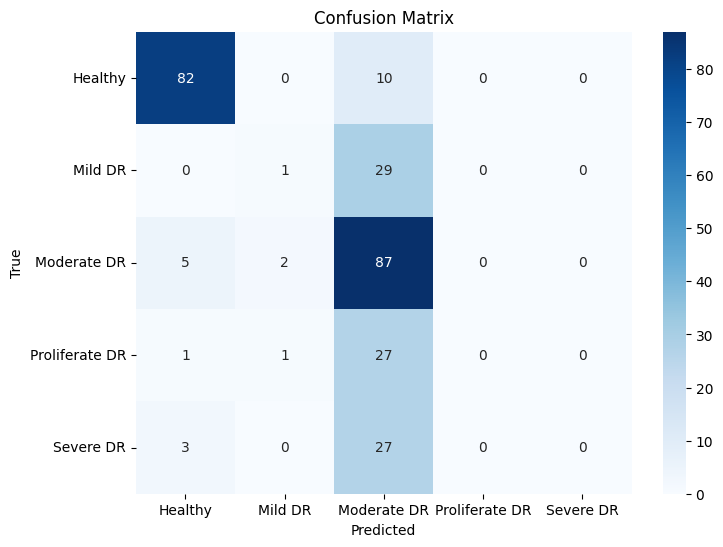

Fold 3/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 27s - loss: 1.0560 - accuracy: 0.5894 - val_loss: 1.0419 - val_accuracy: 0.6293 - 27s/epoch - 881ms/step
Epoch 2/50
31/31 - 23s - loss: 0.9378 - accuracy: 0.6348 - val_loss: 0.9283 - val_accuracy: 0.6263 - 23s/epoch - 734ms/step
Epoch 3/50
31/31 - 23s - loss: 0.8961 - accuracy: 0.6429 - val_loss: 0.8653 - val_accuracy: 0.6500 - 23s/epoch - 744ms/step
Epoch 4/50
31/31 - 22s - loss: 0.8898 - accuracy: 0.6419 - val_loss: 0.8532 - val_accuracy: 0.6505 - 22s/epoch - 722ms/step
Epoch 5/50
31/31 - 23s - loss: 0.8649 - accuracy: 0.6540 - val_loss: 0.8525 - val_accuracy: 0.6586 - 23s/epoch - 734ms/step
Epoch 6/50
31/31 - 23s - loss: 0.8541 - accuracy: 0.6601 - val_loss: 0.8734 - val_accuracy: 0.6626 - 23s/epoch - 729ms/step
Epoch 7/50
31/31 - 24s - loss: 0.8429 - accuracy: 0.6525 - val_loss: 0.8477 - val_accuracy: 0.6702 - 24s/epoch - 762ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


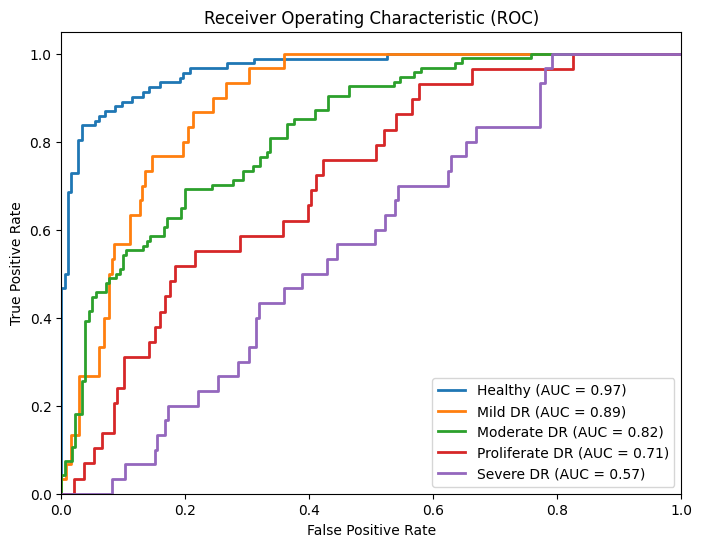

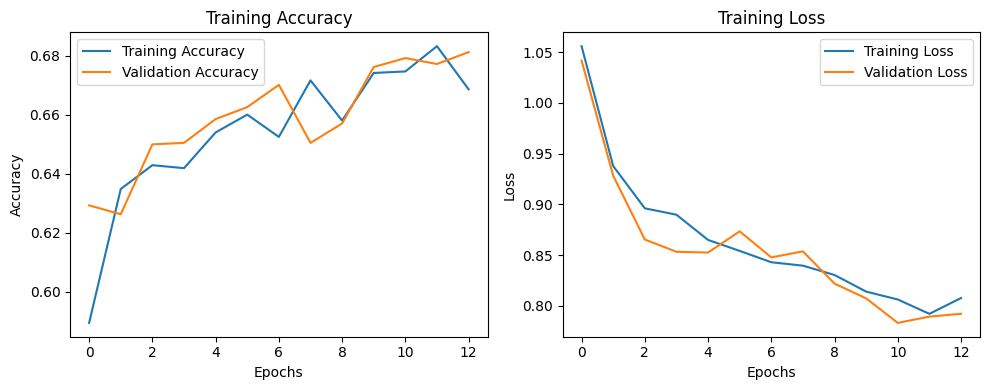

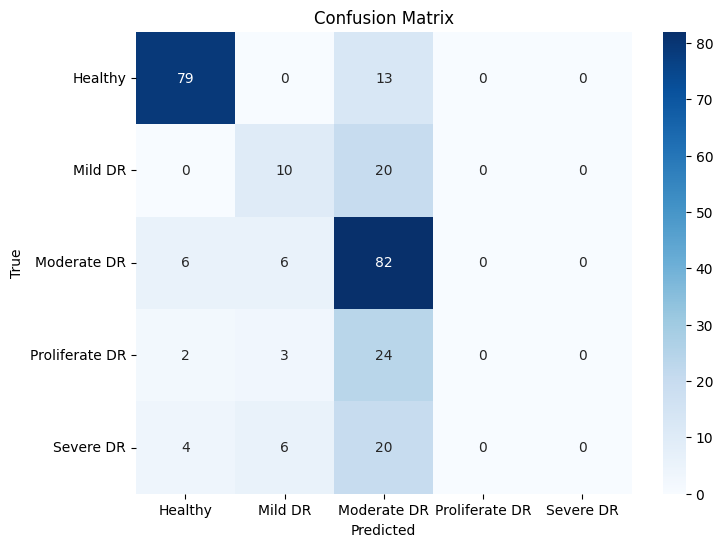

Fold 4/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 29s - loss: 1.0714 - accuracy: 0.5823 - val_loss: 0.9415 - val_accuracy: 0.6369 - 29s/epoch - 939ms/step
Epoch 2/50
31/31 - 24s - loss: 0.9299 - accuracy: 0.6298 - val_loss: 0.9395 - val_accuracy: 0.6313 - 24s/epoch - 790ms/step
Epoch 3/50
31/31 - 24s - loss: 0.8888 - accuracy: 0.6530 - val_loss: 0.9187 - val_accuracy: 0.6652 - 24s/epoch - 773ms/step
Epoch 4/50
31/31 - 23s - loss: 0.8720 - accuracy: 0.6525 - val_loss: 0.8649 - val_accuracy: 0.6556 - 23s/epoch - 757ms/step
Epoch 5/50
31/31 - 24s - loss: 0.8667 - accuracy: 0.6530 - val_loss: 0.8570 - val_accuracy: 0.6545 - 24s/epoch - 769ms/step
Epoch 6/50
31/31 - 24s - loss: 0.8548 - accuracy: 0.6520 - val_loss: 0.8594 - val_accuracy: 0.6394 - 24s/epoch - 765ms/step
Epoch 7/50
31/31 - 23s - loss: 0.8640 - accuracy: 0.6576 - val_loss: 0.8722 - val_accuracy: 0.6768 - 23s/epoch - 755ms/step
5/5

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


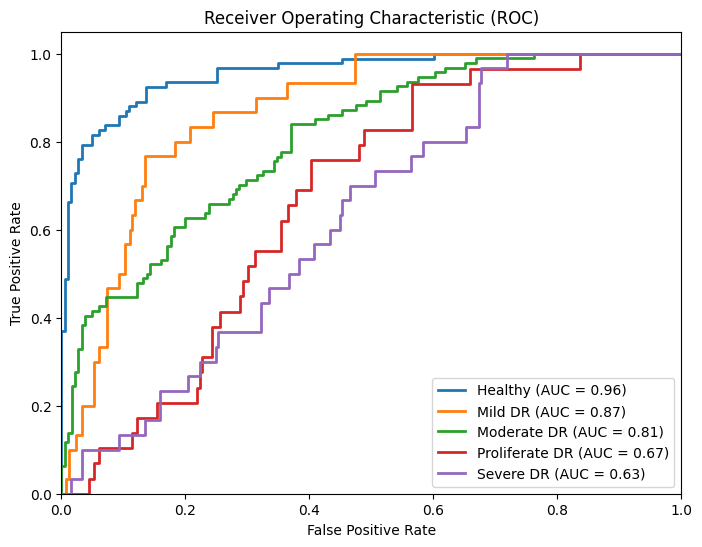

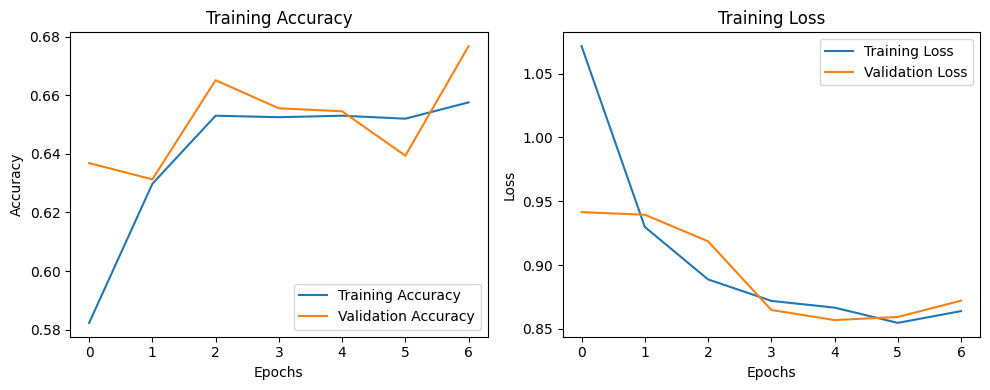

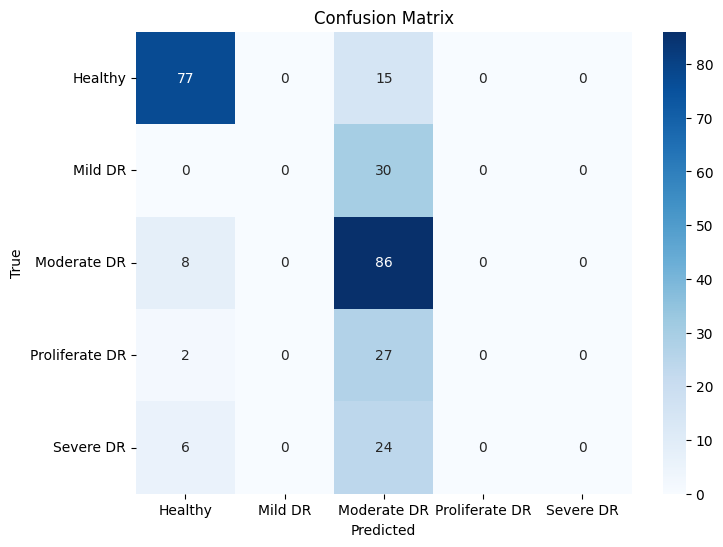

Fold 5/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 28s - loss: 1.1020 - accuracy: 0.5525 - val_loss: 0.9775 - val_accuracy: 0.6263 - 28s/epoch - 906ms/step
Epoch 2/50
31/31 - 24s - loss: 0.9521 - accuracy: 0.6247 - val_loss: 0.8948 - val_accuracy: 0.6354 - 24s/epoch - 763ms/step
Epoch 3/50
31/31 - 24s - loss: 0.9112 - accuracy: 0.6414 - val_loss: 0.9101 - val_accuracy: 0.6323 - 24s/epoch - 759ms/step
Epoch 4/50
31/31 - 24s - loss: 0.8993 - accuracy: 0.6429 - val_loss: 0.8668 - val_accuracy: 0.6500 - 24s/epoch - 790ms/step
Epoch 5/50
31/31 - 33s - loss: 0.8728 - accuracy: 0.6470 - val_loss: 0.8537 - val_accuracy: 0.6566 - 33s/epoch - 1s/step
Epoch 6/50
31/31 - 24s - loss: 0.8576 - accuracy: 0.6525 - val_loss: 0.8818 - val_accuracy: 0.6333 - 24s/epoch - 781ms/step
Epoch 7/50
31/31 - 24s - loss: 0.8419 - accuracy: 0.6505 - val_loss: 0.8318 - val_accuracy: 0.6525 - 24s/epoch - 776ms/step
Epoch 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


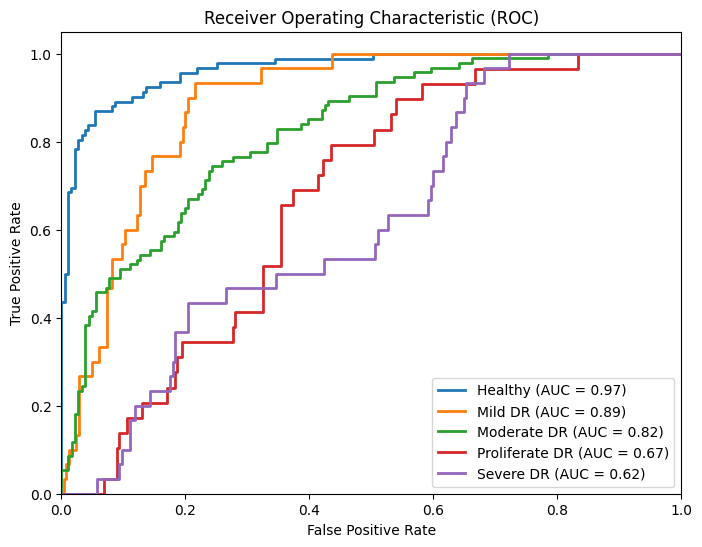

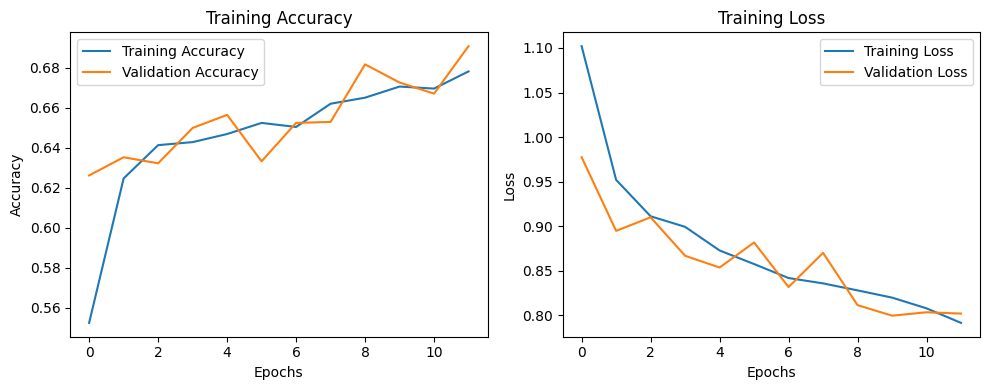

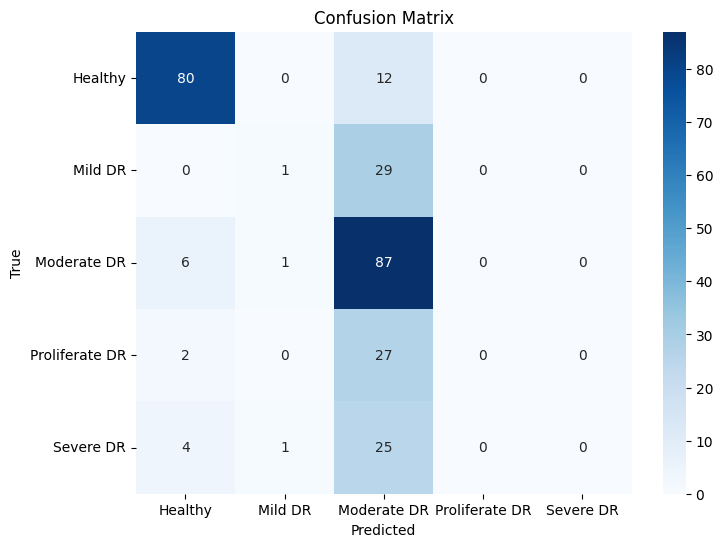

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import ResNet50

# Initialize a list to store the results for each fold
fold_results = []

# Initialize variables to keep track of the best model
best_model = None
best_val_loss = float('inf')  # Set to positive infinity initially

# Loop over the folds
for fold, (train_index, val_index) in enumerate(skf.split(filepaths, labels)):
    print(f"Fold {fold + 1}/{k}")
    
    train_filepaths = filepaths[train_index]
    val_filepaths = filepaths[val_index]
    train_labels = labels[train_index]
    val_labels = labels[val_index]
    
    train_df_fold = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
    val_df_fold = pd.DataFrame({'Filepath': val_filepaths, 'Label': val_labels})
    
    # Create and preprocess the data generators for this fold
    train_generator_fold, _, val_images_fold, test_images_fold = create_gen(train_df_fold, val_df_fold)

    
    # Create the model for this fold
    model = get_model(ResNet50)  # You can change the model architecture here
    
    # Train the model for a fixed number of epochs
    history = model.fit(
        train_images_fold,
        epochs=50,
        validation_data=val_images_fold,
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )
    
    # Evaluate the model on the test data
    evaluate_model(model, test_images)
    
    # Check if the current model's validation loss is better than the best model so far
    if history.history['val_loss'][-1] < best_val_loss:
        best_model = model
        best_val_loss = history.history['val_loss'][-1]
    
    # Append the evaluation results to the fold_results list
    fold_results.append(history)

# Save the best model
best_model.save("best_model_ResNet50.h5")


In [54]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

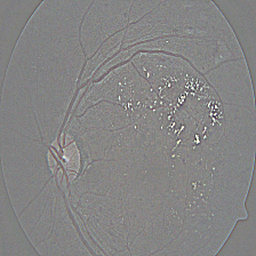

In [58]:
model_builder = keras.applications.ResNet50
img_size = (224, 224)
preprocess_input = keras.applications.resnet.preprocess_input
decode_predictions = keras.applications.resnet.decode_predictions

last_conv_layer_name = "conv5_block3_out"


# The local path to our target image
img_path = "/kaggle/input/diabetic-retinopathy-dataset/Severe DR/Severe DR_101.png"

display(Image(img_path))

In [59]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

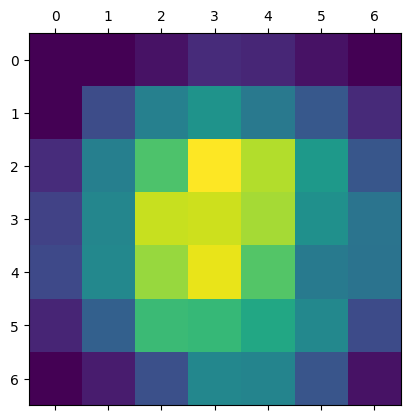

/tmp/ipykernel_28/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


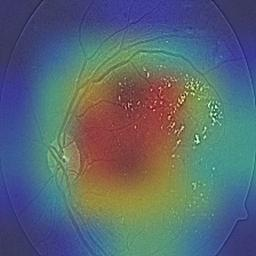

In [60]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model


model = get_model(model_builder)



# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare the image
img_array = keras.applications.xception.preprocess_input(get_img_array(img_path, size=img_size))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad-CAM result
save_and_display_gradcam(img_path, heatmap)


Fold 1/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
31/31 - 44s - loss: 1.1160 - accuracy: 0.5949 - val_loss: 0.9291 - val_accuracy: 0.6419 - 44s/epoch - 1s/step
Epoch 2/50
31/31 - 24s - loss: 0.9222 - accuracy: 0.6475 - val_loss: 0.8680 - val_accuracy: 0.6611 - 24s/epoch - 775ms/step
Epoch 3/50
31/31 - 24s - loss: 0.8365 - accuracy: 0.6707 - val_loss: 0.7996 - val_accuracy: 0.6742 - 24s/epoch - 785ms/step
Epoch 4/50
31/31 - 24s - loss: 0.7929 - accuracy: 0.6864 - val_loss: 0.7829 - val_accuracy: 0.6894 - 24s/epoch - 782ms/step
Epoch 5/50
31/31 - 24s - loss: 0.7686 - accuracy: 0.6939 - val_loss: 0.7467 - val_accuracy: 0.6894 - 24s/epoch - 772ms/step
Epoch 6/50
31/31 - 24s - loss: 0.7410 - accuracy: 0.7040 - val_loss: 0.7262 - val_accuracy: 0.7343 - 24s/epoch - 773ms/step
Epoch 7/50
31/31 - 33s - loss: 0.7209 - accuracy: 0.7237 - val_lo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


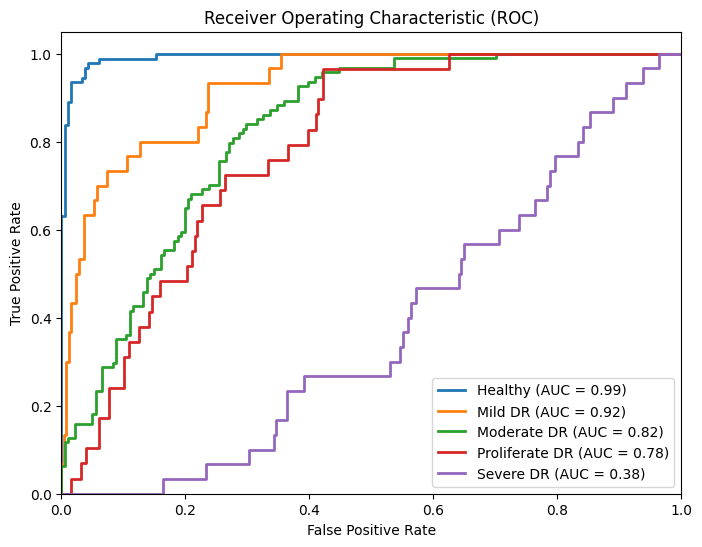

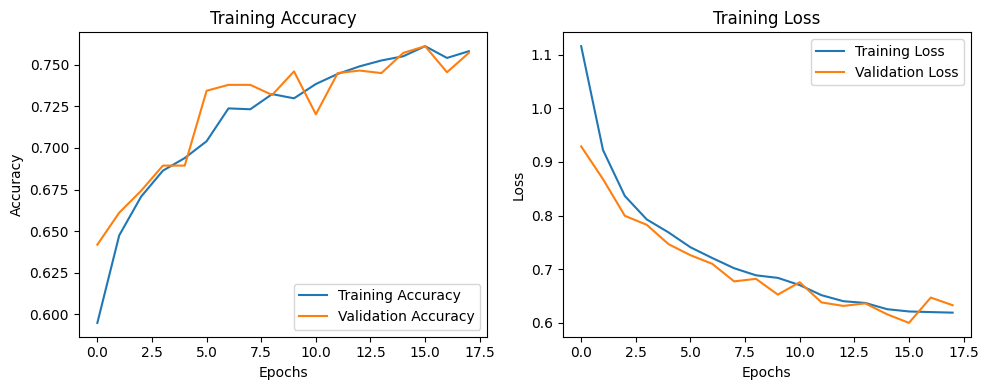

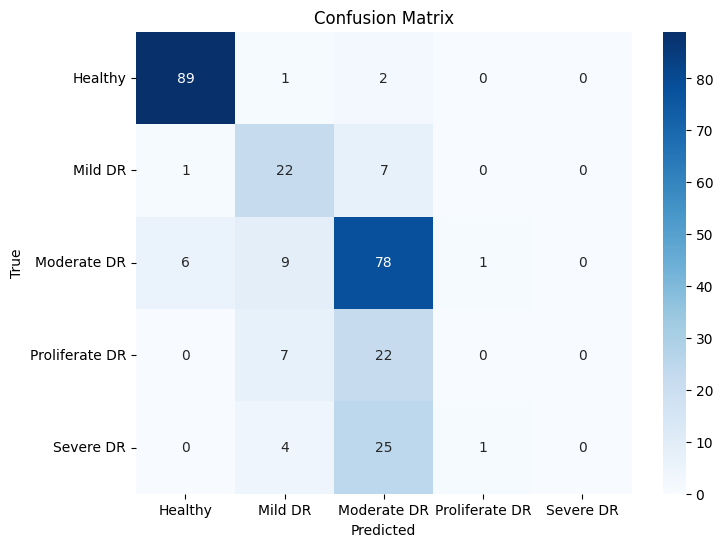

Fold 2/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 25s - loss: 1.0706 - accuracy: 0.6232 - val_loss: 0.9095 - val_accuracy: 0.6374 - 25s/epoch - 811ms/step
Epoch 2/50
31/31 - 23s - loss: 0.8629 - accuracy: 0.6581 - val_loss: 0.8324 - val_accuracy: 0.6763 - 23s/epoch - 744ms/step
Epoch 3/50
31/31 - 24s - loss: 0.8055 - accuracy: 0.6828 - val_loss: 0.7873 - val_accuracy: 0.6828 - 24s/epoch - 759ms/step
Epoch 4/50
31/31 - 24s - loss: 0.7801 - accuracy: 0.6838 - val_loss: 0.7790 - val_accuracy: 0.7045 - 24s/epoch - 764ms/step
Epoch 5/50
31/31 - 24s - loss: 0.7487 - accuracy: 0.7056 - val_loss: 0.7654 - val_accuracy: 0.6874 - 24s/epoch - 769ms/step
Epoch 6/50
31/31 - 24s - loss: 0.7251 - accuracy: 0.7162 - val_loss: 0.7212 - val_accuracy: 0.7197 - 24s/epoch - 772ms/step
Epoch 7/50
31/31 - 24s - loss: 0.6987 - accuracy: 0.7288 - val_loss: 0.7075 - val_accuracy: 0.7348 - 24s/epoch - 764ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


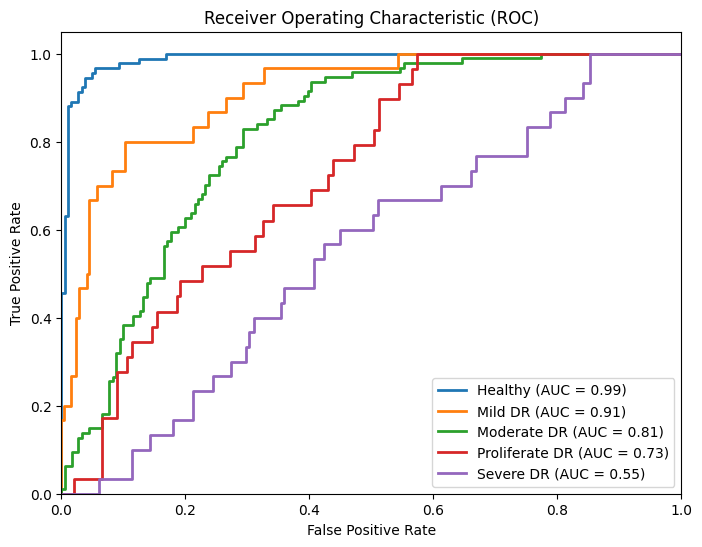

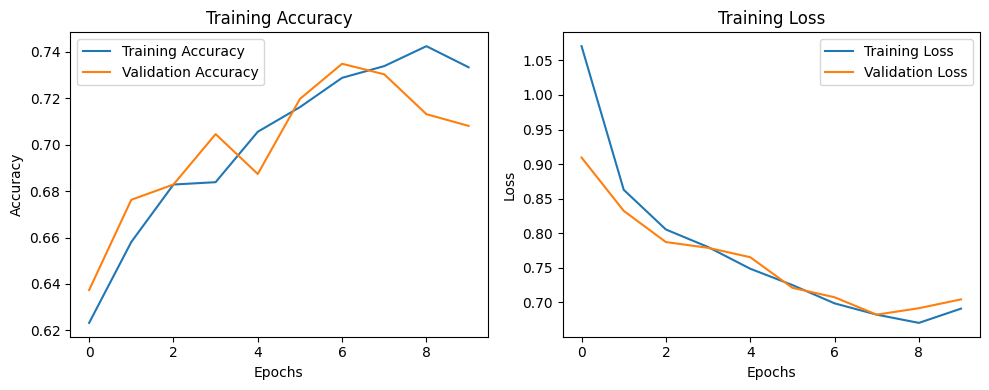

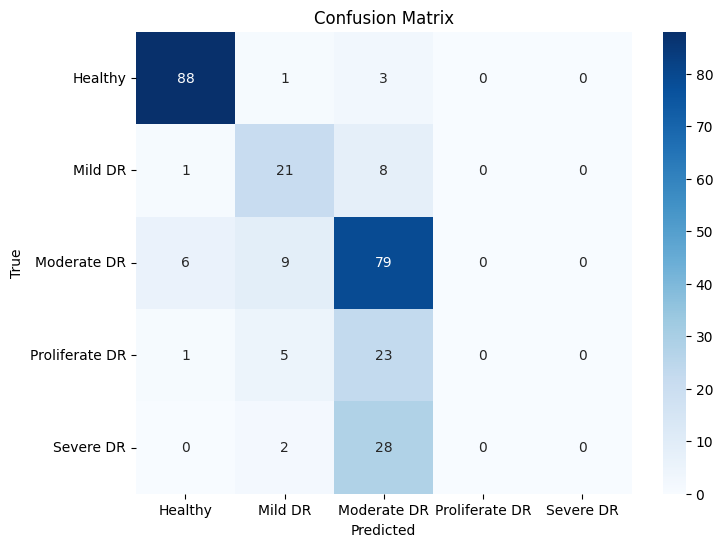

Fold 3/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 25s - loss: 1.1008 - accuracy: 0.6030 - val_loss: 0.9222 - val_accuracy: 0.6379 - 25s/epoch - 816ms/step
Epoch 2/50
31/31 - 23s - loss: 0.8885 - accuracy: 0.6495 - val_loss: 0.8318 - val_accuracy: 0.6732 - 23s/epoch - 750ms/step
Epoch 3/50
31/31 - 24s - loss: 0.8304 - accuracy: 0.6763 - val_loss: 0.7923 - val_accuracy: 0.6904 - 24s/epoch - 775ms/step
Epoch 4/50
31/31 - 23s - loss: 0.7923 - accuracy: 0.6823 - val_loss: 0.7614 - val_accuracy: 0.6939 - 23s/epoch - 756ms/step
Epoch 5/50
31/31 - 23s - loss: 0.7662 - accuracy: 0.6919 - val_loss: 0.7600 - val_accuracy: 0.6924 - 23s/epoch - 735ms/step
Epoch 6/50
31/31 - 23s - loss: 0.7438 - accuracy: 0.6914 - val_loss: 0.7165 - val_accuracy: 0.6985 - 23s/epoch - 748ms/step
Epoch 7/50
31/31 - 24s - loss: 0.7201 - accuracy: 0.7096 - val_loss: 0.7011 - val_accuracy: 0.7081 - 24s/epoch - 772ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


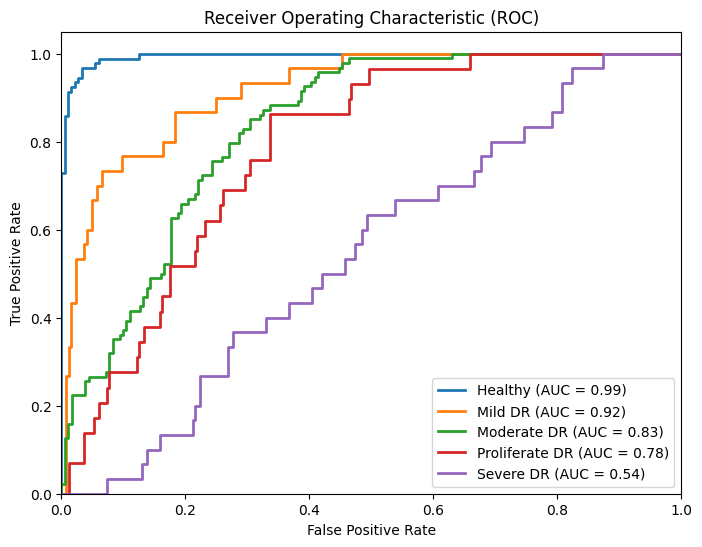

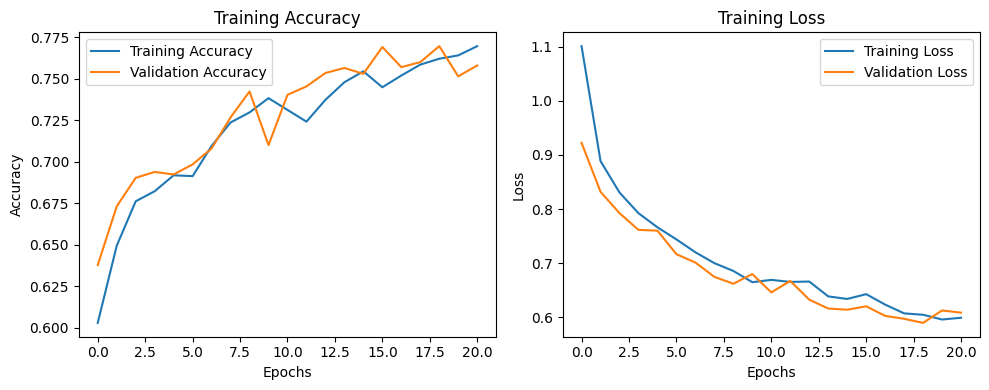

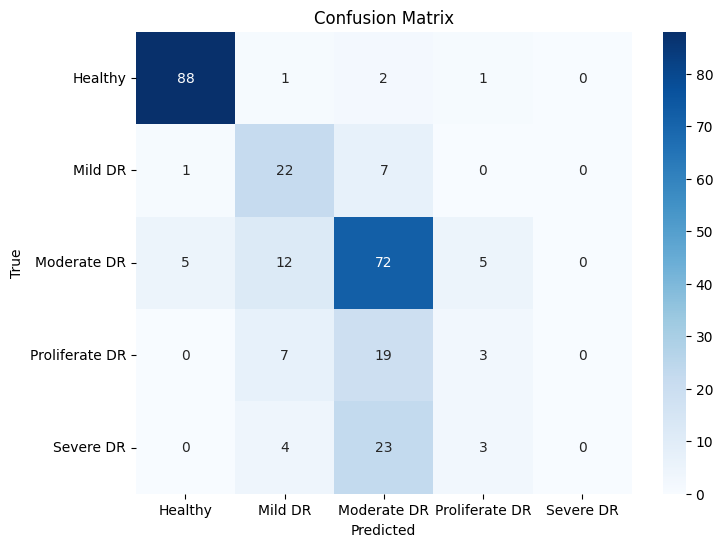

Fold 4/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 24s - loss: 1.0829 - accuracy: 0.6051 - val_loss: 0.9329 - val_accuracy: 0.6364 - 24s/epoch - 786ms/step
Epoch 2/50
31/31 - 24s - loss: 0.8659 - accuracy: 0.6626 - val_loss: 0.8369 - val_accuracy: 0.6707 - 24s/epoch - 762ms/step
Epoch 3/50
31/31 - 22s - loss: 0.8127 - accuracy: 0.6803 - val_loss: 0.8163 - val_accuracy: 0.6737 - 22s/epoch - 722ms/step
Epoch 4/50
31/31 - 23s - loss: 0.7773 - accuracy: 0.6934 - val_loss: 0.7720 - val_accuracy: 0.6869 - 23s/epoch - 748ms/step
Epoch 5/50
31/31 - 24s - loss: 0.7475 - accuracy: 0.7010 - val_loss: 0.7330 - val_accuracy: 0.6949 - 24s/epoch - 762ms/step
Epoch 6/50
31/31 - 24s - loss: 0.7218 - accuracy: 0.7086 - val_loss: 0.7117 - val_accuracy: 0.7076 - 24s/epoch - 765ms/step
Epoch 7/50
31/31 - 23s - loss: 0.6988 - accuracy: 0.7253 - val_loss: 0.6924 - val_accuracy: 0.7177 - 23s/epoch - 755ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


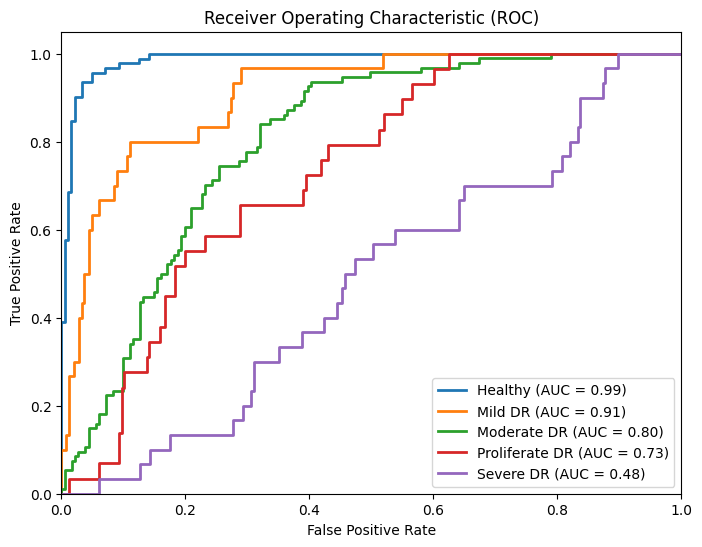

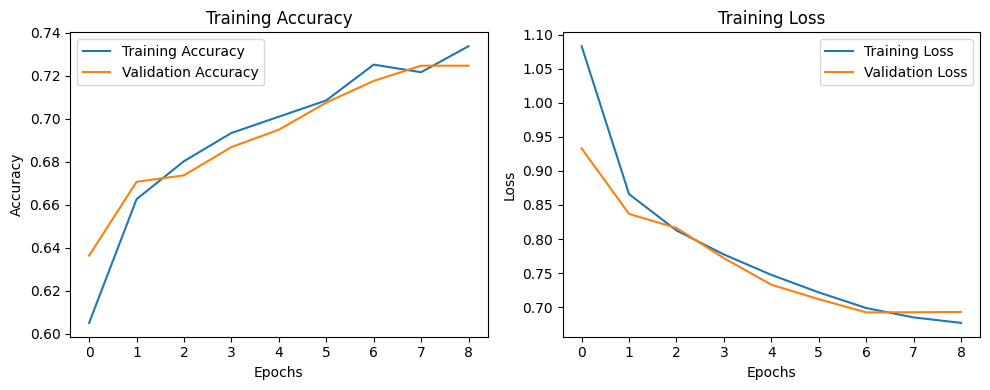

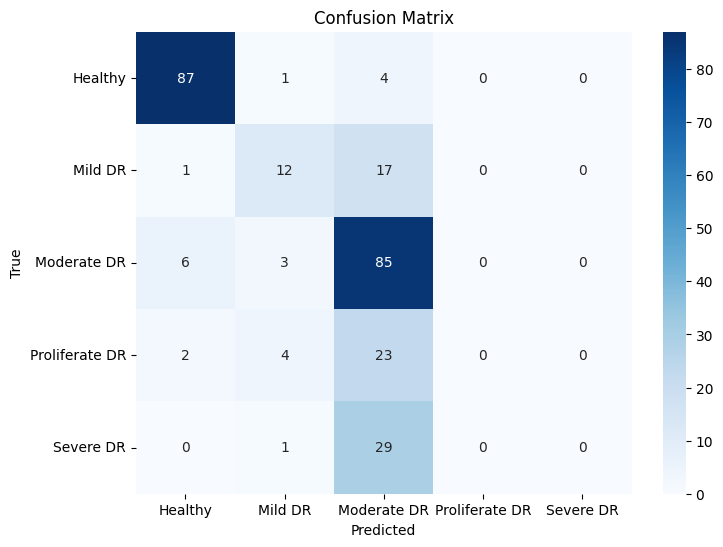

Fold 5/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 26s - loss: 1.1362 - accuracy: 0.5955 - val_loss: 0.9477 - val_accuracy: 0.6359 - 26s/epoch - 823ms/step
Epoch 2/50
31/31 - 24s - loss: 0.8977 - accuracy: 0.6520 - val_loss: 0.8492 - val_accuracy: 0.6621 - 24s/epoch - 760ms/step
Epoch 3/50
31/31 - 22s - loss: 0.8187 - accuracy: 0.6828 - val_loss: 0.7893 - val_accuracy: 0.6919 - 22s/epoch - 721ms/step
Epoch 4/50
31/31 - 23s - loss: 0.7873 - accuracy: 0.6864 - val_loss: 0.7932 - val_accuracy: 0.6869 - 23s/epoch - 747ms/step
Epoch 5/50
31/31 - 24s - loss: 0.7713 - accuracy: 0.6980 - val_loss: 0.7466 - val_accuracy: 0.7076 - 24s/epoch - 759ms/step
Epoch 6/50
31/31 - 24s - loss: 0.7438 - accuracy: 0.7051 - val_loss: 0.7574 - val_accuracy: 0.7081 - 24s/epoch - 760ms/step
Epoch 7/50
31/31 - 24s - loss: 0.7247 - accuracy: 0.7081 - val_loss: 0.7233 - val_accuracy: 0.7293 - 24s/epoch - 766ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


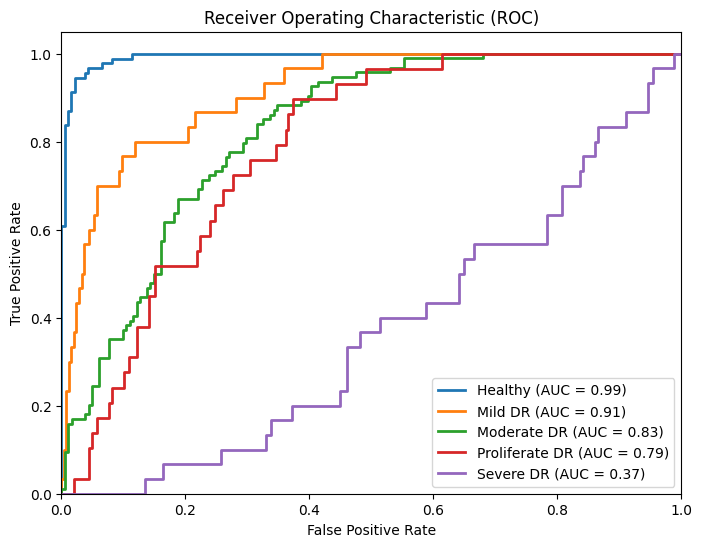

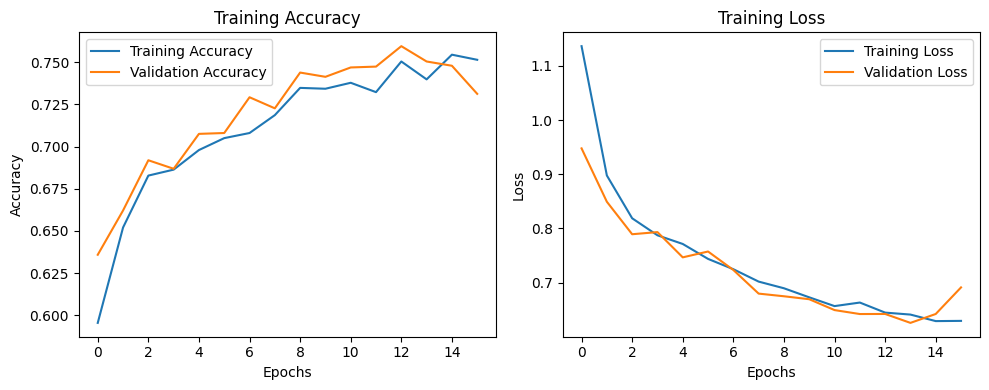

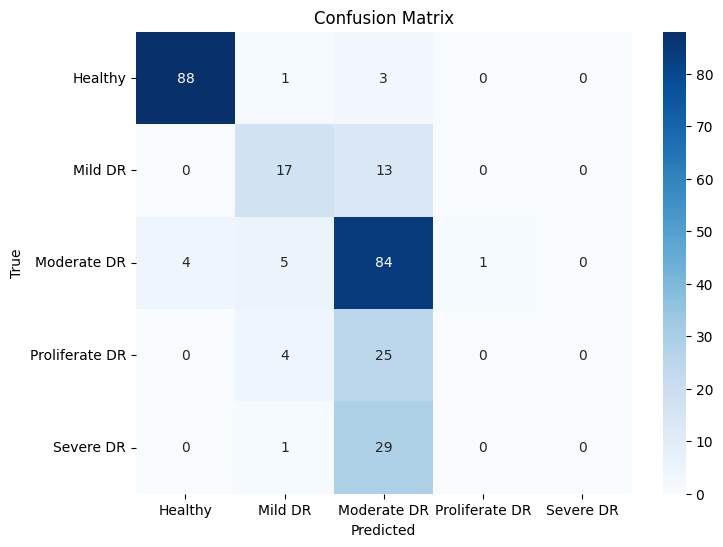

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import VGG16

# Initialize a list to store the results for each fold
fold_results = []

# Initialize variables to keep track of the best model
best_model = None
best_val_loss = float('inf')  # Set to positive infinity initially

# Loop over the folds
for fold, (train_index, val_index) in enumerate(skf.split(filepaths, labels)):
    print(f"Fold {fold + 1}/{k}")
    
    train_filepaths = filepaths[train_index]
    val_filepaths = filepaths[val_index]
    train_labels = labels[train_index]
    val_labels = labels[val_index]
    
    train_df_fold = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
    val_df_fold = pd.DataFrame({'Filepath': val_filepaths, 'Label': val_labels})
    
    # Create and preprocess the data generators for this fold
    train_generator_fold, _, val_images_fold, test_images_fold = create_gen(train_df_fold, val_df_fold)

    
    # Create the model for this fold
    model = get_model(VGG16)  # You can change the model architecture here
    
    # Train the model for a fixed number of epochs
    history = model.fit(
        train_images_fold,
        epochs=50,
        validation_data=val_images_fold,
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )
    
    # Evaluate the model on the test data
    evaluate_model(model, test_images)
    
    # Check if the current model's validation loss is better than the best model so far
    if history.history['val_loss'][-1] < best_val_loss:
        best_model = model
        best_val_loss = history.history['val_loss'][-1]
    
    # Append the evaluation results to the fold_results list
    fold_results.append(history)

# Save the best model
best_model.save("best_model_VGG16.h5")


In [62]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

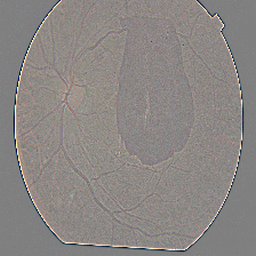

In [66]:
model_builder = keras.applications.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = "/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR/Proliferate DR_103.png"

display(Image(img_path))

In [67]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

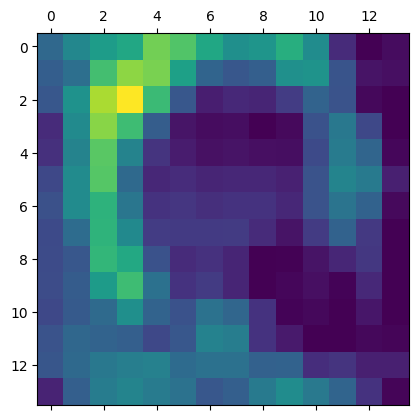

/tmp/ipykernel_28/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


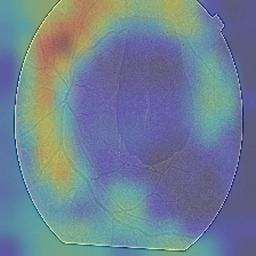

In [68]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model


model = get_model(model_builder)



# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare the image
img_array = keras.applications.xception.preprocess_input(get_img_array(img_path, size=img_size))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad-CAM result
save_and_display_gradcam(img_path, heatmap)


Fold 1/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
31/31 - 26s - loss: 0.8847 - accuracy: 0.6636 - val_loss: 0.6689 - val_accuracy: 0.7439 - 26s/epoch - 850ms/step
Epoch 2/50
31/31 - 21s - loss: 0.6568 - accuracy: 0.7419 - val_loss: 0.5811 - val_accuracy: 0.7778 - 21s/epoch - 688ms/step
Epoch 3/50
31/31 - 21s - loss: 0.5837 - accuracy: 0.7692 - val_loss: 0.5491 - val_accuracy: 0.7773 - 21s/epoch - 693ms/step
Epoch 4/50
31/31 - 21s - loss: 0.5540 - accuracy: 0.7818 - val_loss: 0.5119 - val_accuracy: 0.8040 - 21s/epoch - 681ms/step
Epoch 5/50
31/31 - 21s - loss: 0.5194 - accuracy: 0.7980 - val_loss: 0.4644 - val_accuracy: 0.8146 - 21s/epoch - 662ms/step
Epoch 6/50
31/31 - 21s - loss: 0.4660 - accuracy: 0.8146 - val_loss: 0.4343 - val_accuracy: 0.8414 - 21s/epoch - 672ms/step
Epoch 7/50
31/31 - 21s - loss: 0.4531 - accuracy: 0.8192 - val_l

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


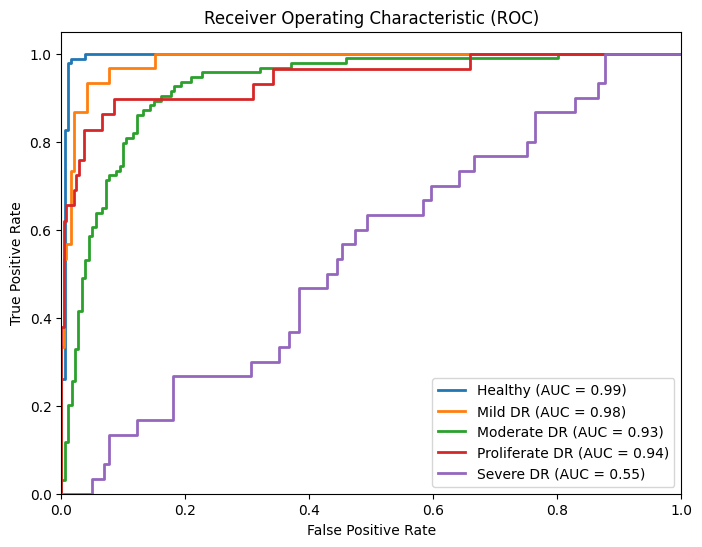

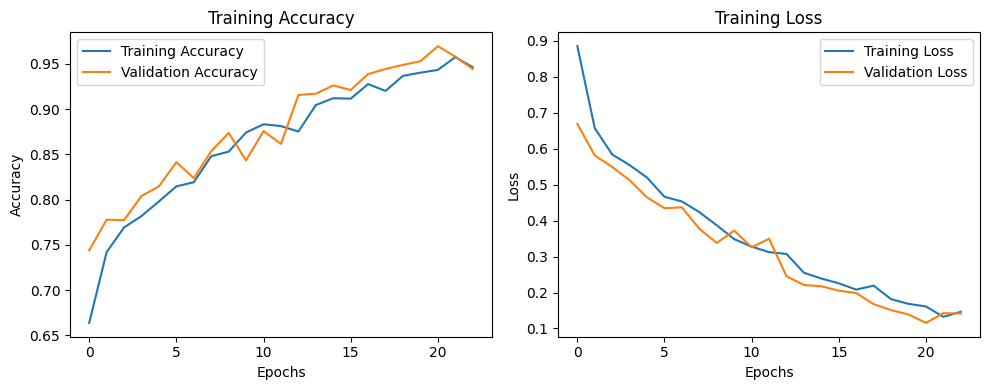

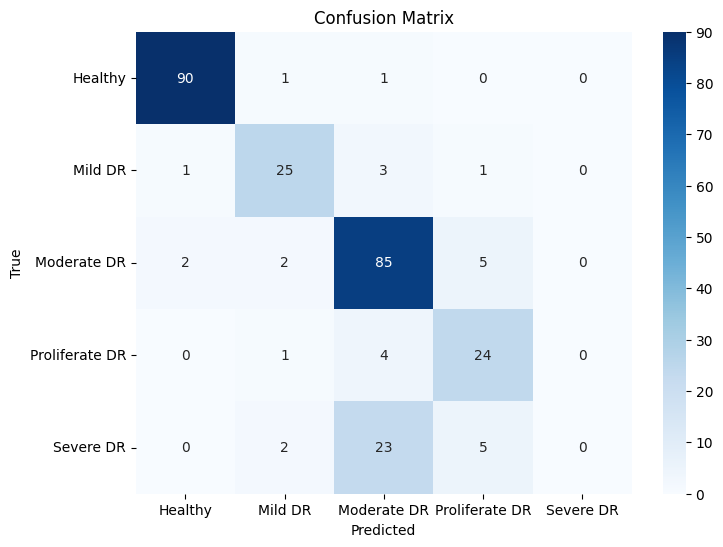

Fold 2/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 25s - loss: 0.8940 - accuracy: 0.6566 - val_loss: 0.7307 - val_accuracy: 0.7121 - 25s/epoch - 817ms/step
Epoch 2/50
31/31 - 21s - loss: 0.6567 - accuracy: 0.7424 - val_loss: 0.6014 - val_accuracy: 0.7768 - 21s/epoch - 663ms/step
Epoch 3/50
31/31 - 21s - loss: 0.5760 - accuracy: 0.7833 - val_loss: 0.5533 - val_accuracy: 0.7848 - 21s/epoch - 677ms/step
Epoch 4/50
31/31 - 20s - loss: 0.5987 - accuracy: 0.7490 - val_loss: 0.5323 - val_accuracy: 0.7949 - 20s/epoch - 650ms/step
Epoch 5/50
31/31 - 19s - loss: 0.4979 - accuracy: 0.8101 - val_loss: 0.5333 - val_accuracy: 0.7864 - 19s/epoch - 627ms/step
Epoch 6/50
31/31 - 21s - loss: 0.4631 - accuracy: 0.8263 - val_loss: 0.4936 - val_accuracy: 0.8076 - 21s/epoch - 686ms/step
Epoch 7/50
31/31 - 21s - loss: 0.4510 - accuracy: 0.8333 - val_loss: 0.4602 - val_accuracy: 0.8303 - 21s/epoch - 675ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


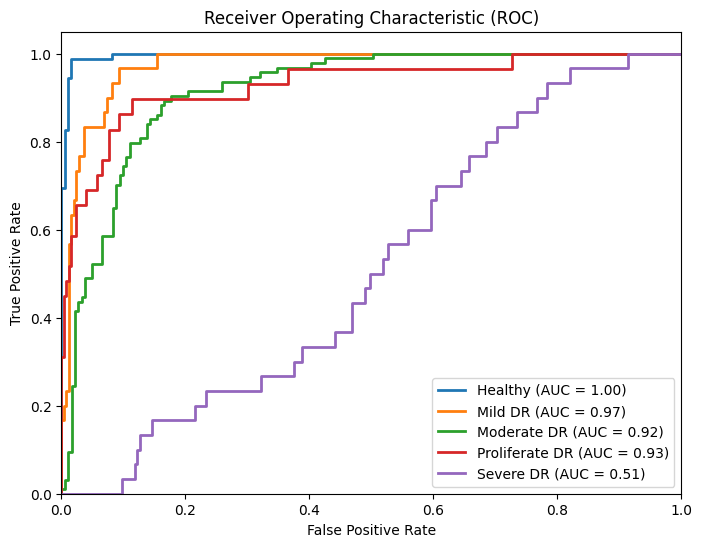

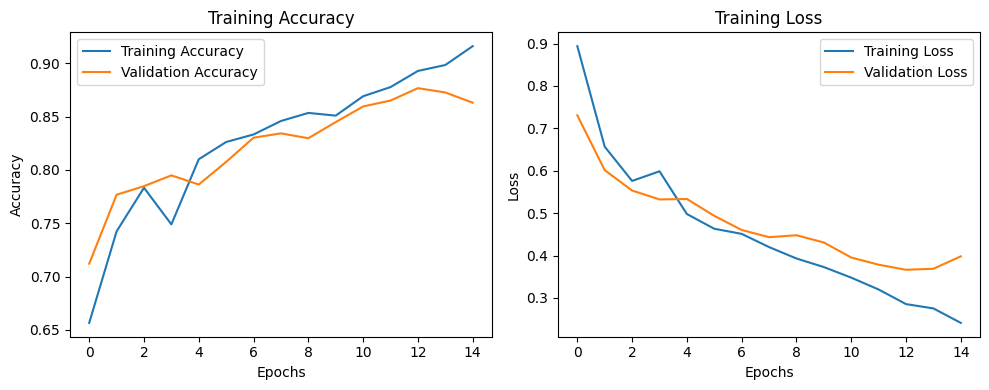

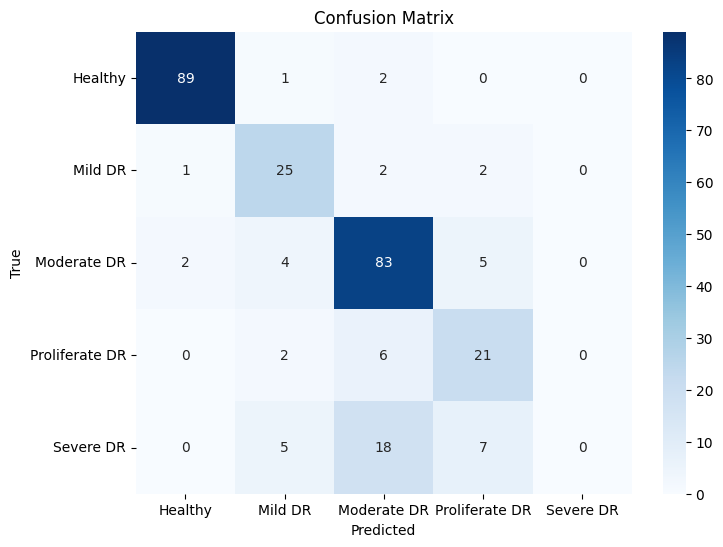

Fold 3/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 25s - loss: 0.8750 - accuracy: 0.6722 - val_loss: 0.6644 - val_accuracy: 0.7455 - 25s/epoch - 792ms/step
Epoch 2/50
31/31 - 21s - loss: 0.6483 - accuracy: 0.7530 - val_loss: 0.5805 - val_accuracy: 0.7717 - 21s/epoch - 688ms/step
Epoch 3/50
31/31 - 20s - loss: 0.5899 - accuracy: 0.7753 - val_loss: 0.5787 - val_accuracy: 0.7763 - 20s/epoch - 661ms/step
Epoch 4/50
31/31 - 21s - loss: 0.5632 - accuracy: 0.7742 - val_loss: 0.5699 - val_accuracy: 0.7586 - 21s/epoch - 664ms/step
Epoch 5/50
31/31 - 20s - loss: 0.5150 - accuracy: 0.8051 - val_loss: 0.5049 - val_accuracy: 0.8081 - 20s/epoch - 656ms/step
Epoch 6/50
31/31 - 21s - loss: 0.4793 - accuracy: 0.8146 - val_loss: 0.4741 - val_accuracy: 0.8227 - 21s/epoch - 672ms/step
Epoch 7/50
31/31 - 21s - loss: 0.4550 - accuracy: 0.8242 - val_loss: 0.4752 - val_accuracy: 0.8126 - 21s/epoch - 677ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


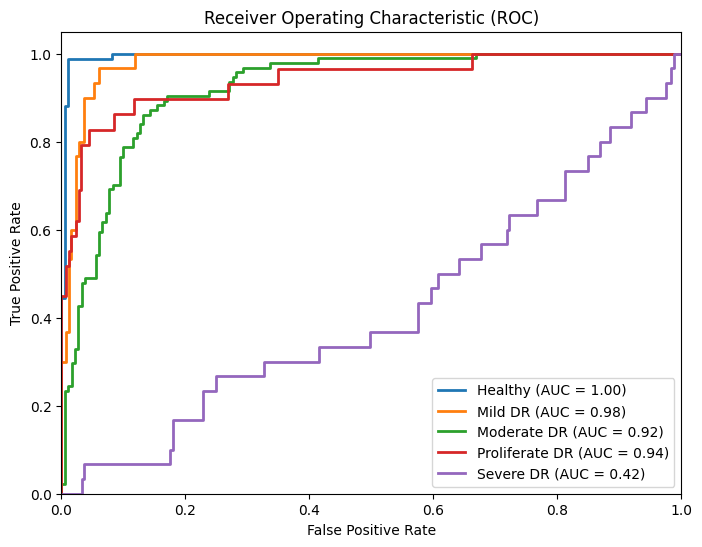

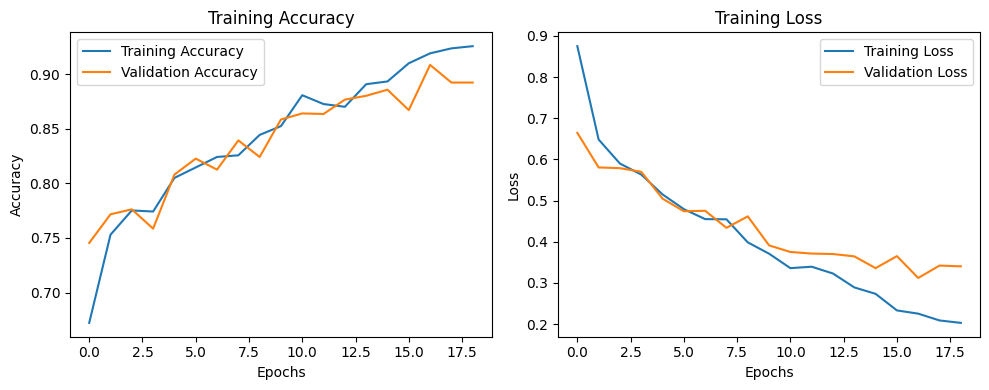

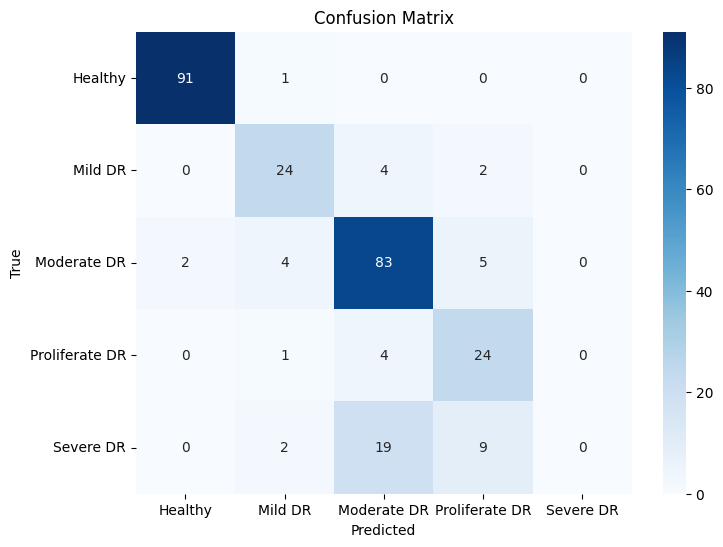

Fold 4/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 25s - loss: 0.8256 - accuracy: 0.6919 - val_loss: 0.7101 - val_accuracy: 0.7202 - 25s/epoch - 795ms/step
Epoch 2/50
31/31 - 21s - loss: 0.6502 - accuracy: 0.7465 - val_loss: 0.6281 - val_accuracy: 0.7591 - 21s/epoch - 687ms/step
Epoch 3/50
31/31 - 21s - loss: 0.5825 - accuracy: 0.7687 - val_loss: 0.5963 - val_accuracy: 0.7611 - 21s/epoch - 671ms/step
Epoch 4/50
31/31 - 21s - loss: 0.5845 - accuracy: 0.7753 - val_loss: 0.6187 - val_accuracy: 0.7475 - 21s/epoch - 684ms/step
Epoch 5/50
31/31 - 21s - loss: 0.5079 - accuracy: 0.8015 - val_loss: 0.4936 - val_accuracy: 0.8141 - 21s/epoch - 670ms/step
Epoch 6/50
31/31 - 20s - loss: 0.4609 - accuracy: 0.8217 - val_loss: 0.5092 - val_accuracy: 0.8076 - 20s/epoch - 641ms/step
Epoch 7/50
31/31 - 21s - loss: 0.4320 - accuracy: 0.8374 - val_loss: 0.4333 - val_accuracy: 0.8328 - 21s/epoch - 683ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


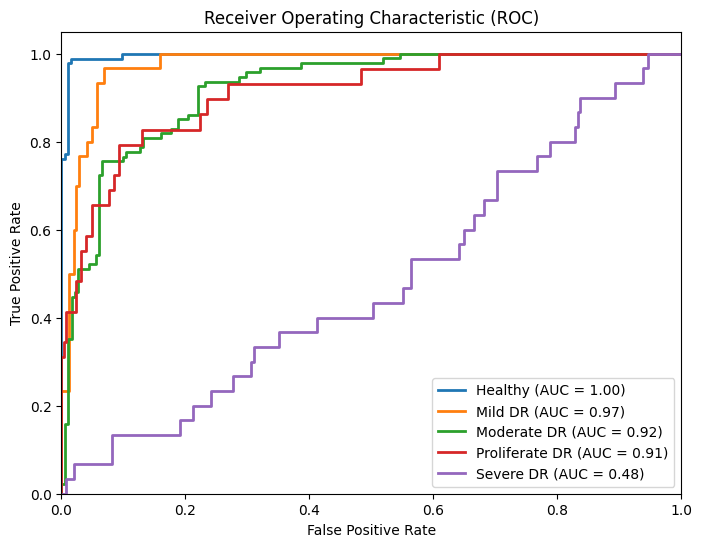

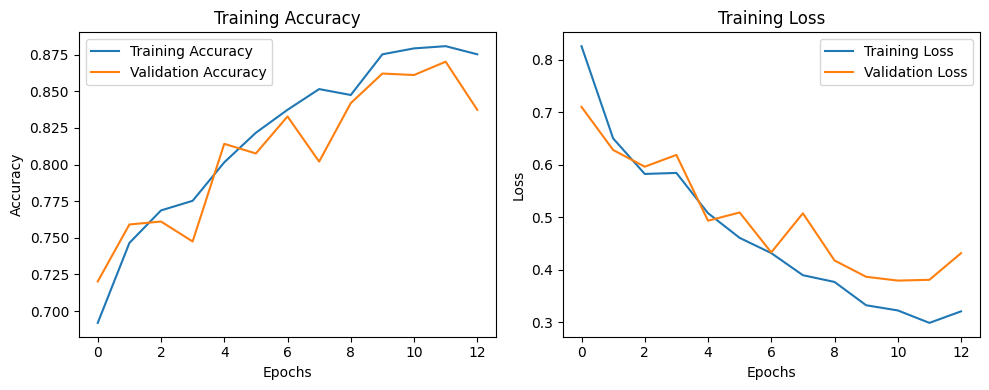

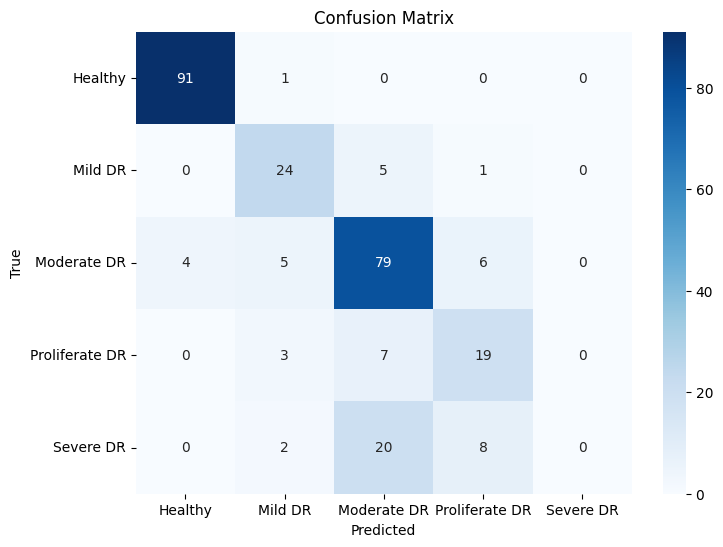

Fold 5/5
Found 1980 validated image filenames belonging to 5 classes.
Found 55 validated image filenames belonging to 5 classes.
Epoch 1/50
31/31 - 26s - loss: 0.9083 - accuracy: 0.6606 - val_loss: 0.6598 - val_accuracy: 0.7545 - 26s/epoch - 837ms/step
Epoch 2/50
31/31 - 21s - loss: 0.6459 - accuracy: 0.7475 - val_loss: 0.5770 - val_accuracy: 0.7773 - 21s/epoch - 689ms/step
Epoch 3/50
31/31 - 21s - loss: 0.5840 - accuracy: 0.7707 - val_loss: 0.5685 - val_accuracy: 0.7667 - 21s/epoch - 680ms/step
Epoch 4/50
31/31 - 30s - loss: 0.5563 - accuracy: 0.7813 - val_loss: 0.5594 - val_accuracy: 0.7823 - 30s/epoch - 971ms/step
Epoch 5/50
31/31 - 21s - loss: 0.5240 - accuracy: 0.7970 - val_loss: 0.5455 - val_accuracy: 0.7672 - 21s/epoch - 663ms/step
Epoch 6/50
31/31 - 22s - loss: 0.5096 - accuracy: 0.7955 - val_loss: 0.4807 - val_accuracy: 0.8177 - 22s/epoch - 696ms/step
Epoch 7/50
31/31 - 21s - loss: 0.4395 - accuracy: 0.8278 - val_loss: 0.5203 - val_accuracy: 0.7924 - 21s/epoch - 679ms/step
Epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


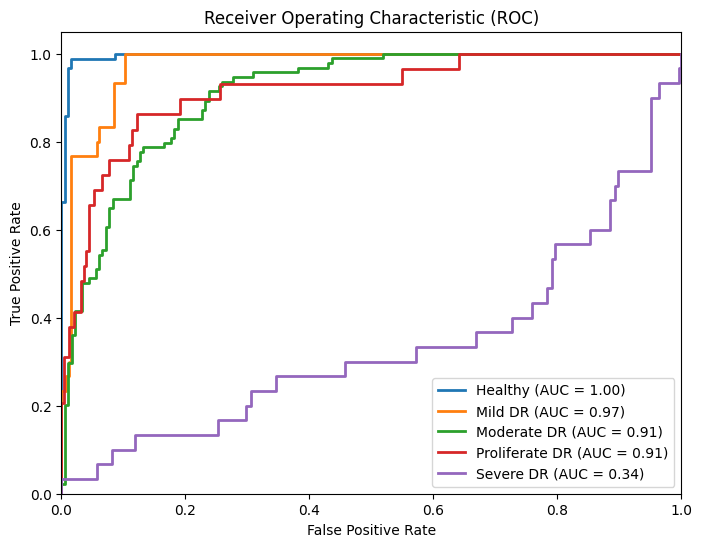

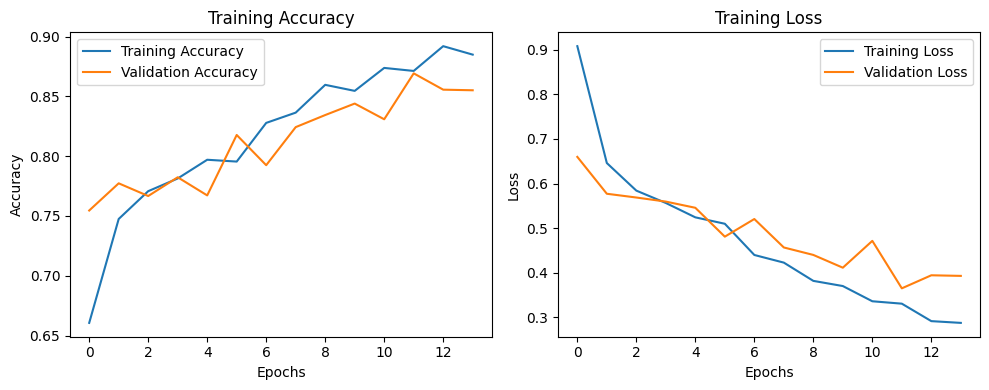

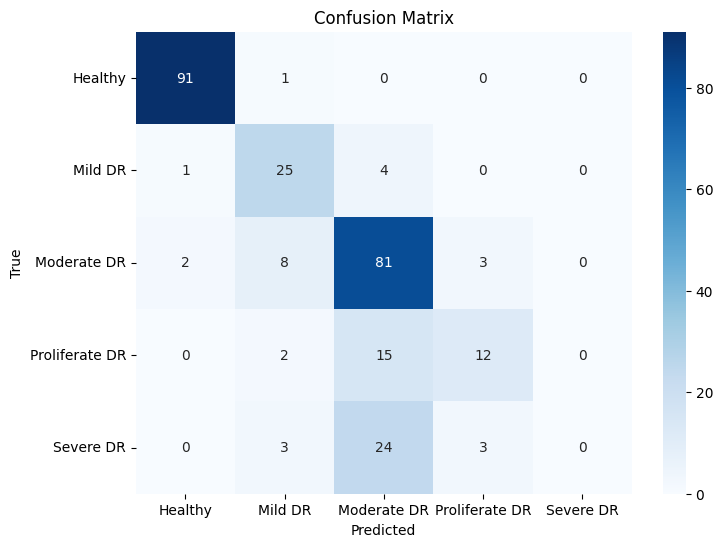

In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import MobileNetV2

# Initialize a list to store the results for each fold
fold_results = []

# Initialize variables to keep track of the best model
best_model = None
best_val_loss = float('inf')  # Set to positive infinity initially

# Loop over the folds
for fold, (train_index, val_index) in enumerate(skf.split(filepaths, labels)):
    print(f"Fold {fold + 1}/{k}")
    
    train_filepaths = filepaths[train_index]
    val_filepaths = filepaths[val_index]
    train_labels = labels[train_index]
    val_labels = labels[val_index]
    
    train_df_fold = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
    val_df_fold = pd.DataFrame({'Filepath': val_filepaths, 'Label': val_labels})
    
    # Create and preprocess the data generators for this fold
    train_generator_fold, _, val_images_fold, test_images_fold = create_gen(train_df_fold, val_df_fold)

    
    # Create the model for this fold
    model = get_model(MobileNetV2)  # You can change the model architecture here
    
    # Train the model for a fixed number of epochs
    history = model.fit(
        train_images_fold,
        epochs=50,
        validation_data=val_images_fold,
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )
    
    # Evaluate the model on the test data
    evaluate_model(model, test_images)
    
    # Check if the current model's validation loss is better than the best model so far
    if history.history['val_loss'][-1] < best_val_loss:
        best_model = model
        best_val_loss = history.history['val_loss'][-1]
    
    # Append the evaluation results to the fold_results list
    fold_results.append(history)

# Save the best model
best_model.save("best_model_MobileNetV2.h5")


In [71]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

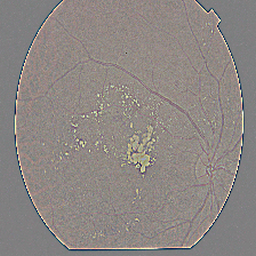

In [75]:
model_builder = keras.applications.MobileNetV2
img_size = (224, 224)
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
decode_predictions = keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "out_relu"

# The local path to our target image
img_path = "/kaggle/input/diabetic-retinopathy-dataset/Moderate DR/Moderate_DR_108.png"

display(Image(img_path))

In [76]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

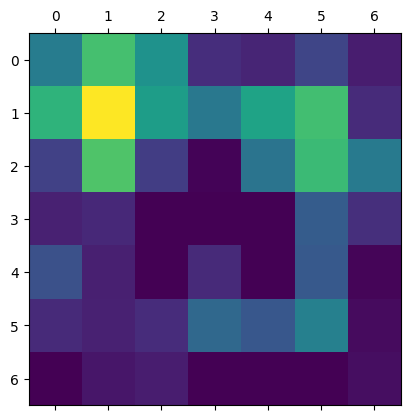

/tmp/ipykernel_28/2437998364.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


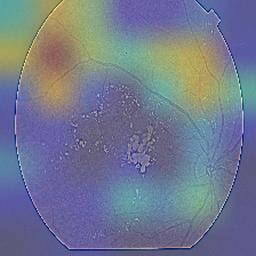

In [77]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model


model = get_model(model_builder)



# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare the image
img_array = keras.applications.xception.preprocess_input(get_img_array(img_path, size=img_size))

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad-CAM result
save_and_display_gradcam(img_path, heatmap)


In [78]:
# Define the models
models = []

# InceptionV3
MobileNetV2_model = get_model(MobileNetV2)
models.append(("MobileNetV2", MobileNetV2_model))

# VGG16
vgg_model = get_model(VGG16)
models.append(("VGG16", vgg_model))

# ResNet50
resnet_model = get_model(ResNet50)
models.append(("ResNet50", resnet_model))

# DenseNet121
densenet_model = get_model(DenseNet121)
models.append(("DenseNet121", densenet_model))

# Custom CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models.append(("Custom CNN", cnn_model))



In [79]:
from tensorflow.keras.callbacks import EarlyStopping

Training MobileNetV2...
Epoch 1/50
35/35 - 19s - loss: 0.9940 - accuracy: 0.6378 - val_loss: 0.7959 - val_accuracy: 0.7166 - 19s/epoch - 552ms/step
Epoch 2/50
35/35 - 13s - loss: 0.7838 - accuracy: 0.7020 - val_loss: 0.7202 - val_accuracy: 0.7368 - 13s/epoch - 368ms/step
Epoch 3/50
35/35 - 14s - loss: 0.7424 - accuracy: 0.7240 - val_loss: 0.7960 - val_accuracy: 0.7085 - 14s/epoch - 399ms/step
Epoch 4/50
35/35 - 13s - loss: 0.6791 - accuracy: 0.7401 - val_loss: 0.6974 - val_accuracy: 0.7449 - 13s/epoch - 363ms/step
Epoch 5/50
35/35 - 13s - loss: 0.6362 - accuracy: 0.7554 - val_loss: 0.6907 - val_accuracy: 0.7409 - 13s/epoch - 369ms/step
Epoch 6/50
35/35 - 13s - loss: 0.5981 - accuracy: 0.7760 - val_loss: 0.6496 - val_accuracy: 0.7733 - 13s/epoch - 384ms/step
Epoch 7/50
35/35 - 13s - loss: 0.5762 - accuracy: 0.7787 - val_loss: 0.6179 - val_accuracy: 0.7652 - 13s/epoch - 374ms/step
Epoch 8/50
35/35 - 13s - loss: 0.5265 - accuracy: 0.8030 - val_loss: 0.6967 - val_accuracy: 0.7530 - 13s/epo

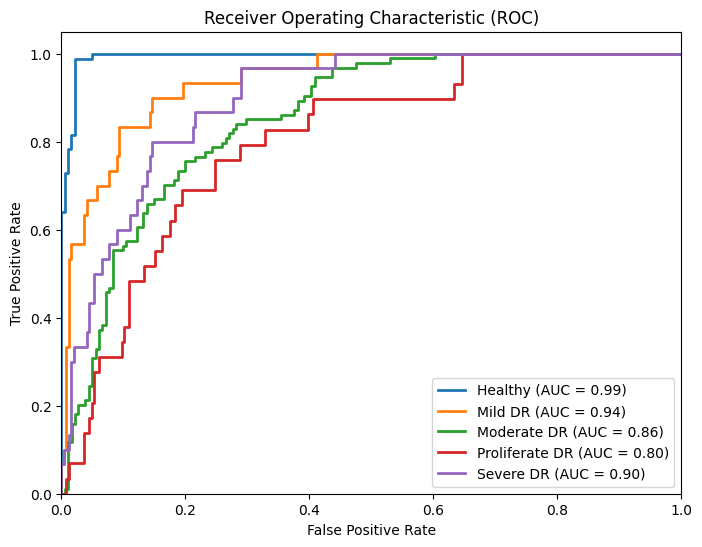

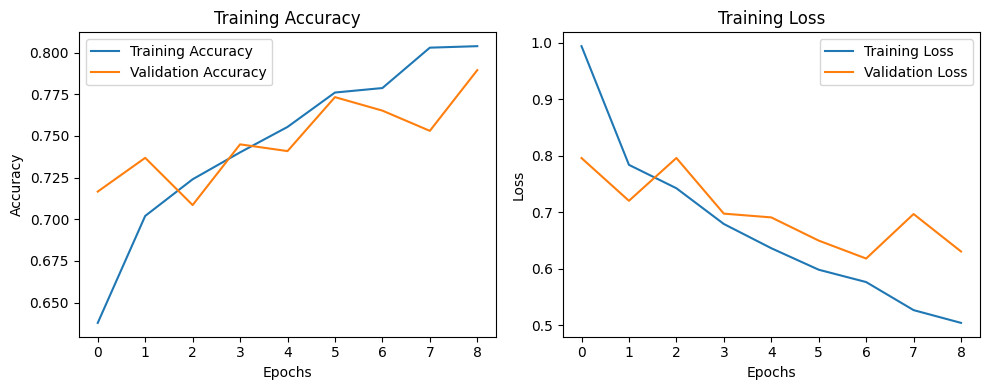

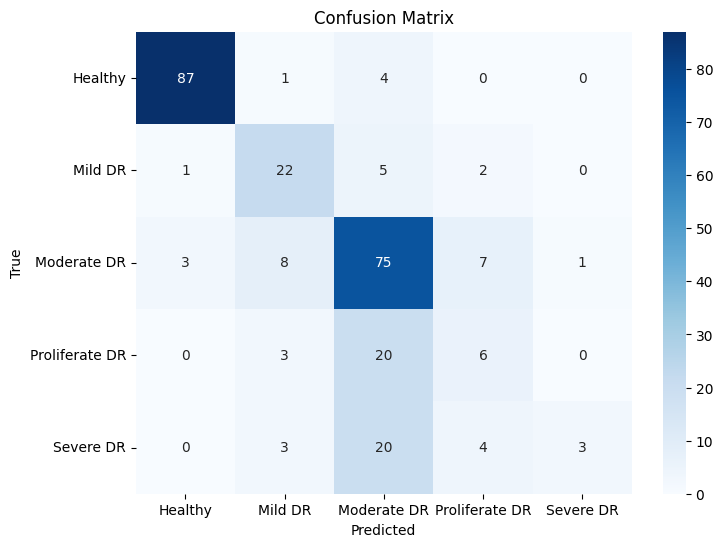

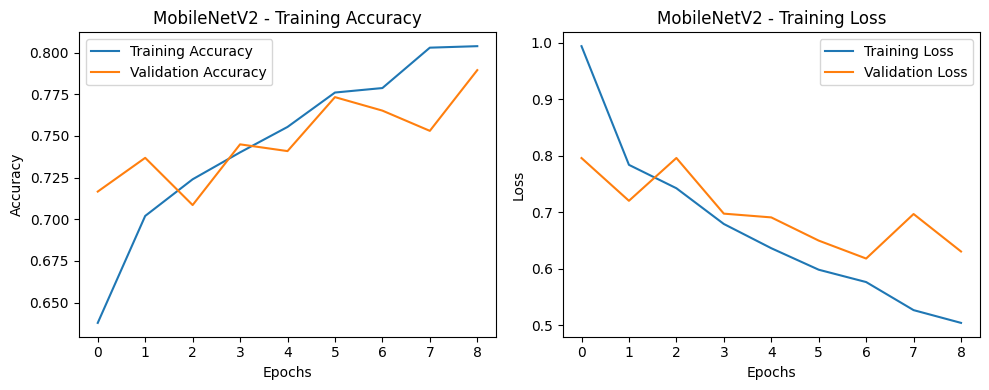

Training VGG16...
Epoch 1/50
35/35 - 30s - loss: 1.2378 - accuracy: 0.5579 - val_loss: 1.0581 - val_accuracy: 0.5911 - 30s/epoch - 859ms/step
Epoch 2/50
35/35 - 15s - loss: 1.0280 - accuracy: 0.6131 - val_loss: 0.9629 - val_accuracy: 0.6356 - 15s/epoch - 423ms/step
Epoch 3/50
35/35 - 15s - loss: 0.9516 - accuracy: 0.6414 - val_loss: 0.8829 - val_accuracy: 0.6680 - 15s/epoch - 435ms/step
Epoch 4/50
35/35 - 15s - loss: 0.9137 - accuracy: 0.6481 - val_loss: 0.8238 - val_accuracy: 0.6842 - 15s/epoch - 423ms/step
Epoch 5/50
35/35 - 14s - loss: 0.8831 - accuracy: 0.6643 - val_loss: 0.8358 - val_accuracy: 0.7045 - 14s/epoch - 393ms/step
Epoch 6/50
35/35 - 15s - loss: 0.8693 - accuracy: 0.6697 - val_loss: 0.7784 - val_accuracy: 0.7126 - 15s/epoch - 416ms/step
Epoch 7/50
35/35 - 14s - loss: 0.8462 - accuracy: 0.6813 - val_loss: 0.7926 - val_accuracy: 0.7247 - 14s/epoch - 394ms/step
Epoch 8/50
35/35 - 14s - loss: 0.8561 - accuracy: 0.6692 - val_loss: 0.7650 - val_accuracy: 0.7004 - 14s/epoch - 4

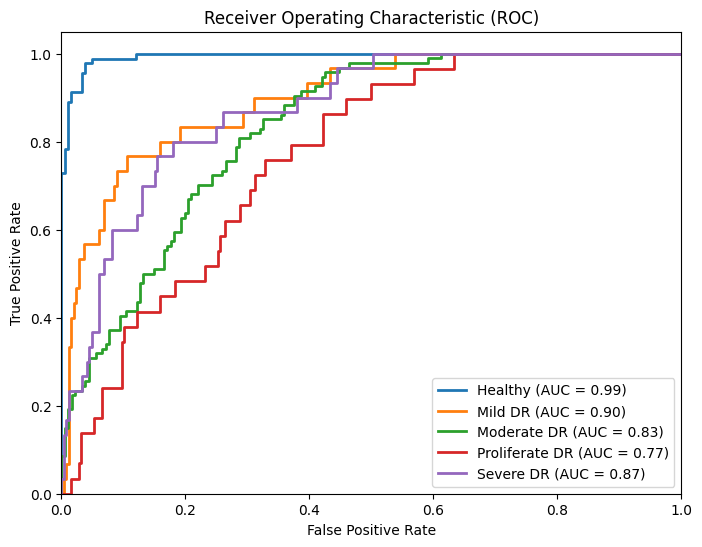

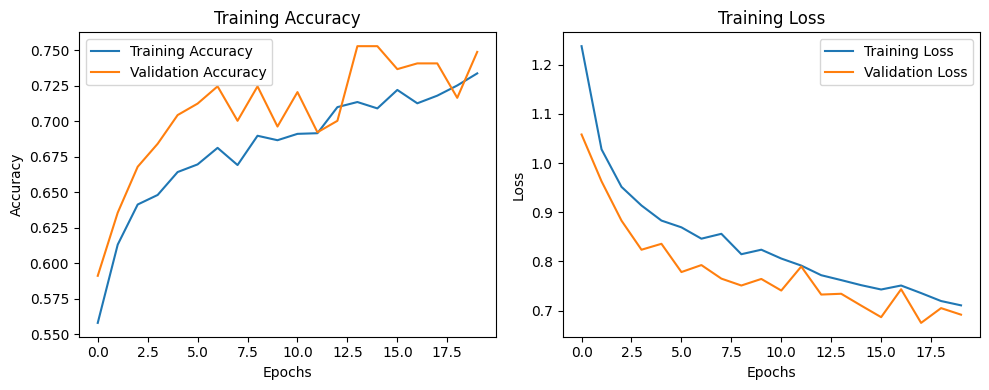

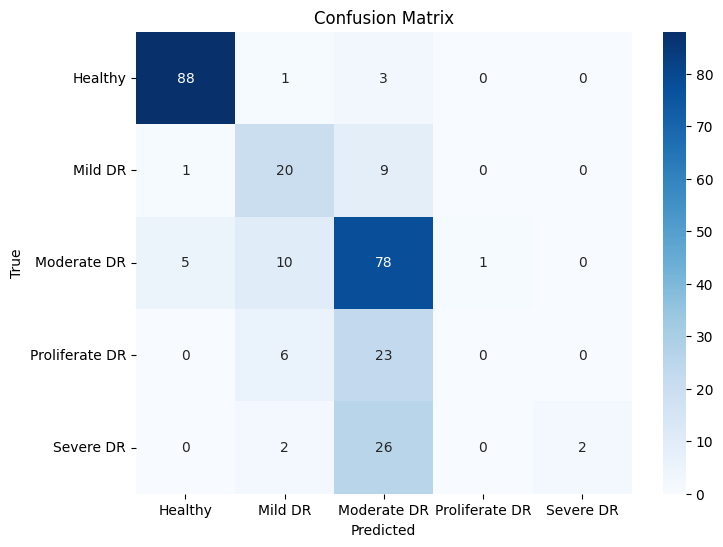

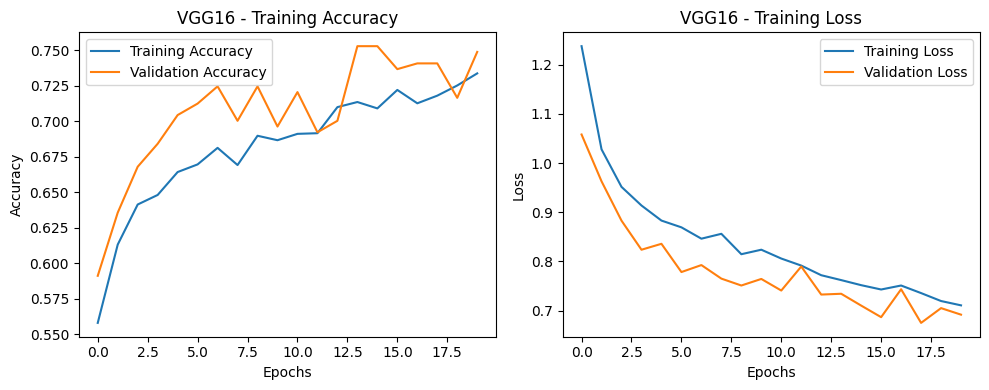

Training ResNet50...
Epoch 1/50
35/35 - 23s - loss: 1.1991 - accuracy: 0.5516 - val_loss: 1.0843 - val_accuracy: 0.6073 - 23s/epoch - 658ms/step
Epoch 2/50
35/35 - 13s - loss: 1.0638 - accuracy: 0.6014 - val_loss: 1.0275 - val_accuracy: 0.6397 - 13s/epoch - 379ms/step
Epoch 3/50
35/35 - 14s - loss: 1.0295 - accuracy: 0.6118 - val_loss: 1.0144 - val_accuracy: 0.6356 - 14s/epoch - 397ms/step
Epoch 4/50
35/35 - 15s - loss: 1.0363 - accuracy: 0.6100 - val_loss: 1.0490 - val_accuracy: 0.6478 - 15s/epoch - 417ms/step
Epoch 5/50
35/35 - 13s - loss: 1.0382 - accuracy: 0.6091 - val_loss: 0.9850 - val_accuracy: 0.6113 - 13s/epoch - 373ms/step
Epoch 6/50
35/35 - 14s - loss: 0.9987 - accuracy: 0.6185 - val_loss: 0.9611 - val_accuracy: 0.6802 - 14s/epoch - 404ms/step
Epoch 7/50
35/35 - 13s - loss: 0.9876 - accuracy: 0.6243 - val_loss: 0.9757 - val_accuracy: 0.6883 - 13s/epoch - 369ms/step
Epoch 8/50
35/35 - 14s - loss: 0.9729 - accuracy: 0.6306 - val_loss: 0.9338 - val_accuracy: 0.6316 - 14s/epoch 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


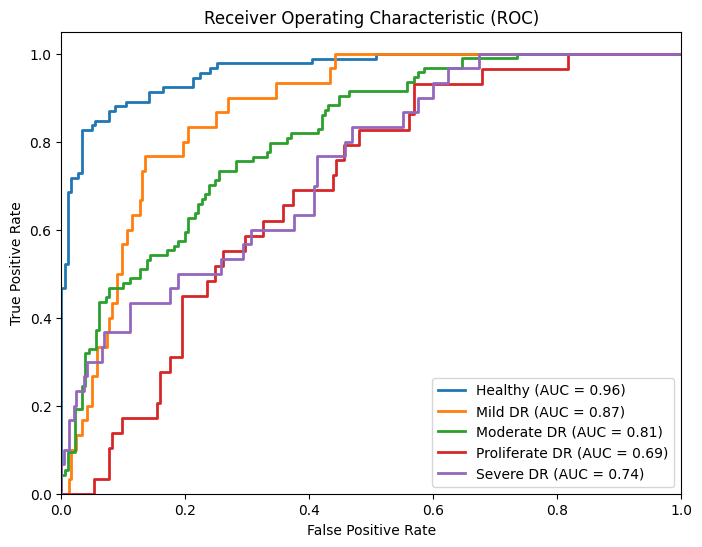

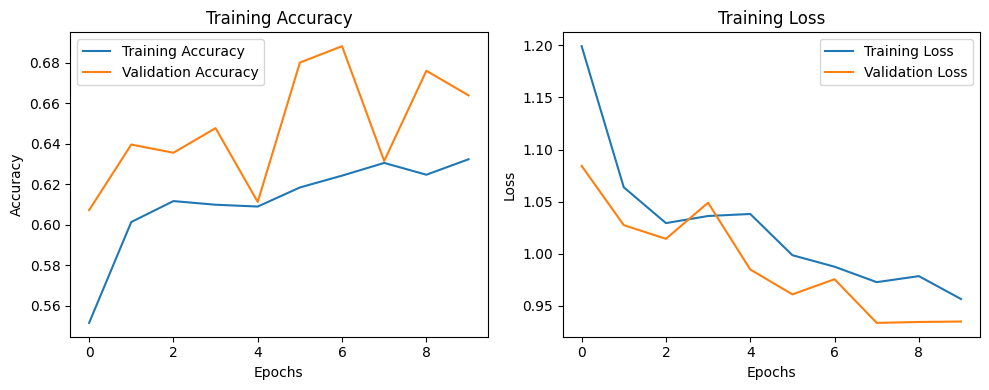

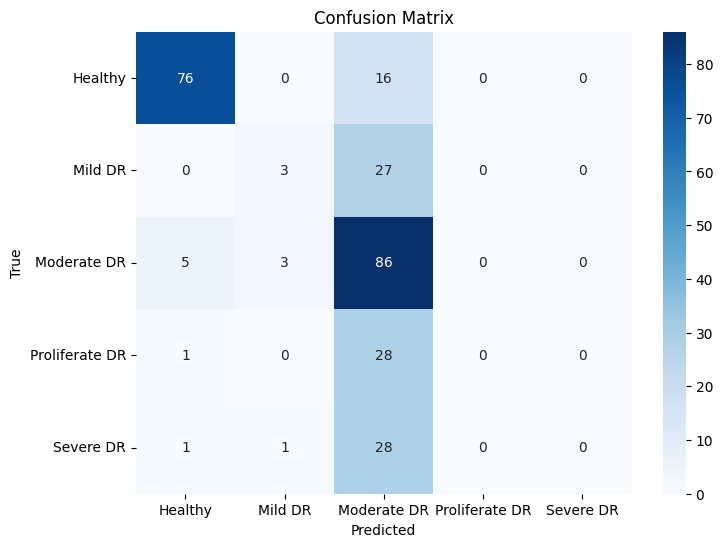

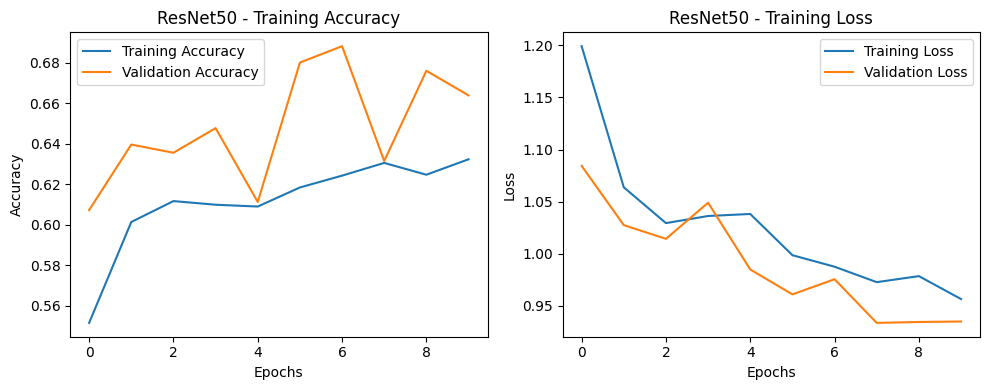

Training DenseNet121...
Epoch 1/50
35/35 - 27s - loss: 1.0773 - accuracy: 0.6073 - val_loss: 0.8473 - val_accuracy: 0.6964 - 27s/epoch - 776ms/step
Epoch 2/50
35/35 - 13s - loss: 0.8436 - accuracy: 0.6917 - val_loss: 0.7773 - val_accuracy: 0.7206 - 13s/epoch - 365ms/step
Epoch 3/50
35/35 - 13s - loss: 0.7822 - accuracy: 0.7033 - val_loss: 0.7061 - val_accuracy: 0.7449 - 13s/epoch - 385ms/step
Epoch 4/50
35/35 - 13s - loss: 0.7500 - accuracy: 0.7069 - val_loss: 0.6981 - val_accuracy: 0.7409 - 13s/epoch - 380ms/step
Epoch 5/50
35/35 - 13s - loss: 0.7035 - accuracy: 0.7285 - val_loss: 0.7015 - val_accuracy: 0.7409 - 13s/epoch - 380ms/step
Epoch 6/50
35/35 - 14s - loss: 0.6823 - accuracy: 0.7352 - val_loss: 0.6360 - val_accuracy: 0.7571 - 14s/epoch - 407ms/step
Epoch 7/50
35/35 - 13s - loss: 0.6593 - accuracy: 0.7522 - val_loss: 0.6717 - val_accuracy: 0.7449 - 13s/epoch - 385ms/step
Epoch 8/50
35/35 - 14s - loss: 0.6679 - accuracy: 0.7504 - val_loss: 0.6924 - val_accuracy: 0.7490 - 14s/epo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


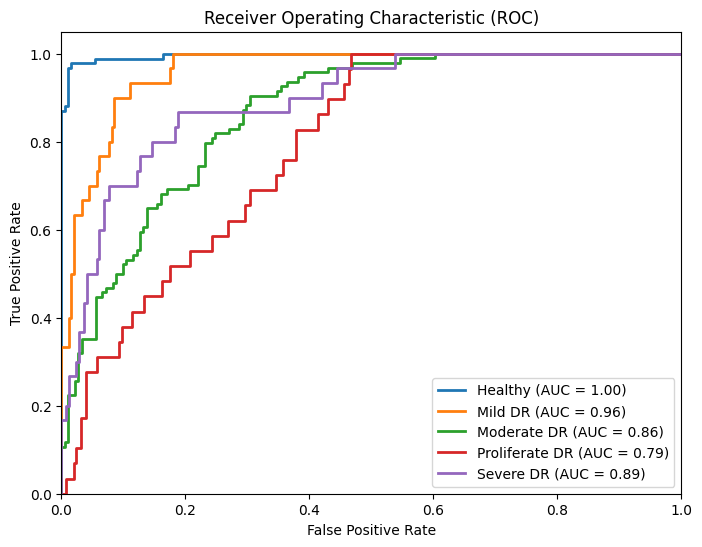

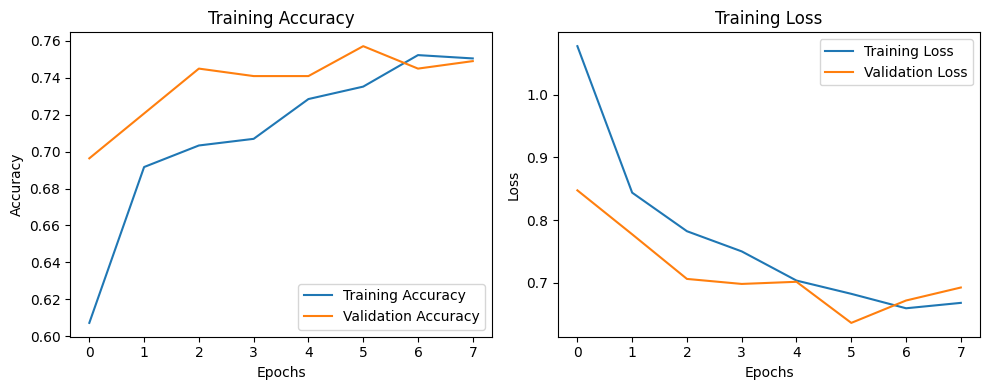

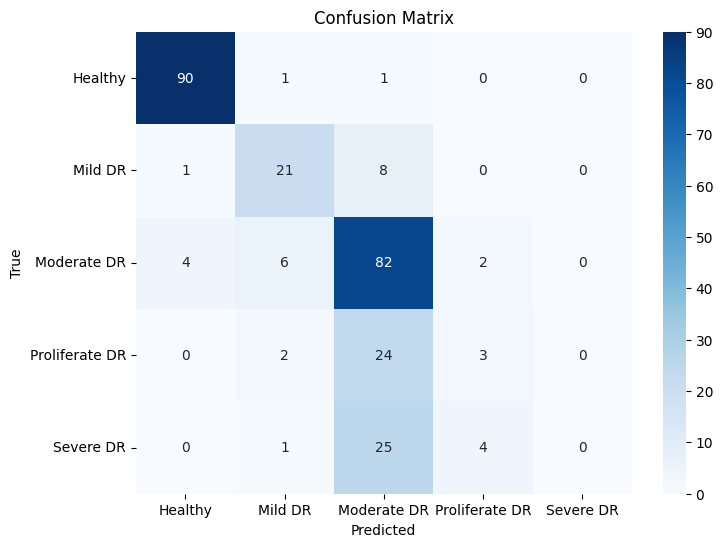

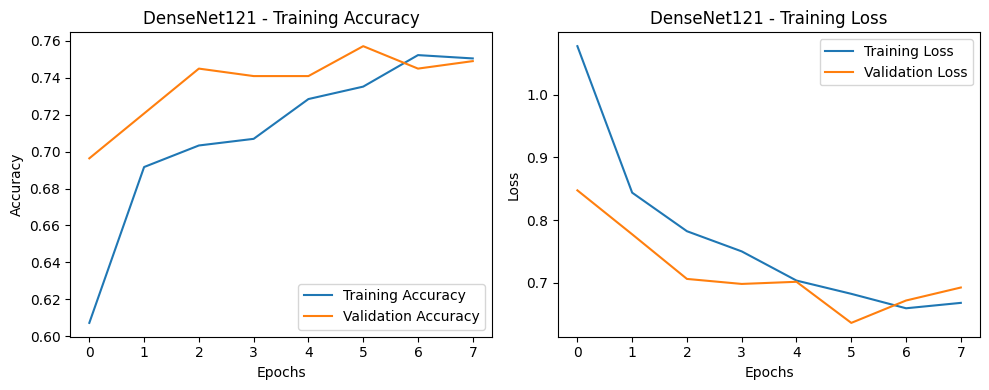

Training Custom CNN...
Epoch 1/50
35/35 - 19s - loss: 1.3694 - accuracy: 0.4026 - val_loss: 1.2417 - val_accuracy: 0.5668 - 19s/epoch - 530ms/step
Epoch 2/50
35/35 - 11s - loss: 1.1243 - accuracy: 0.5987 - val_loss: 1.0463 - val_accuracy: 0.6316 - 11s/epoch - 328ms/step
Epoch 3/50
35/35 - 13s - loss: 1.0277 - accuracy: 0.6216 - val_loss: 1.0151 - val_accuracy: 0.6356 - 13s/epoch - 362ms/step
Epoch 4/50
35/35 - 12s - loss: 0.9888 - accuracy: 0.6369 - val_loss: 0.9214 - val_accuracy: 0.6680 - 12s/epoch - 354ms/step
Epoch 5/50
35/35 - 12s - loss: 0.9777 - accuracy: 0.6387 - val_loss: 0.9545 - val_accuracy: 0.6478 - 12s/epoch - 355ms/step
Epoch 6/50
35/35 - 13s - loss: 0.9672 - accuracy: 0.6382 - val_loss: 0.9184 - val_accuracy: 0.6559 - 13s/epoch - 360ms/step
Epoch 7/50
35/35 - 12s - loss: 0.9567 - accuracy: 0.6396 - val_loss: 0.9141 - val_accuracy: 0.6559 - 12s/epoch - 332ms/step
Epoch 8/50
35/35 - 12s - loss: 0.9558 - accuracy: 0.6427 - val_loss: 0.9426 - val_accuracy: 0.6437 - 12s/epoc

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


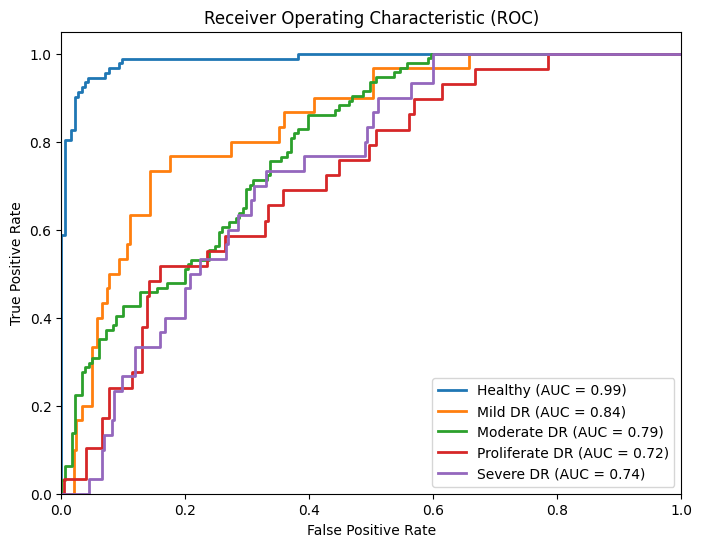

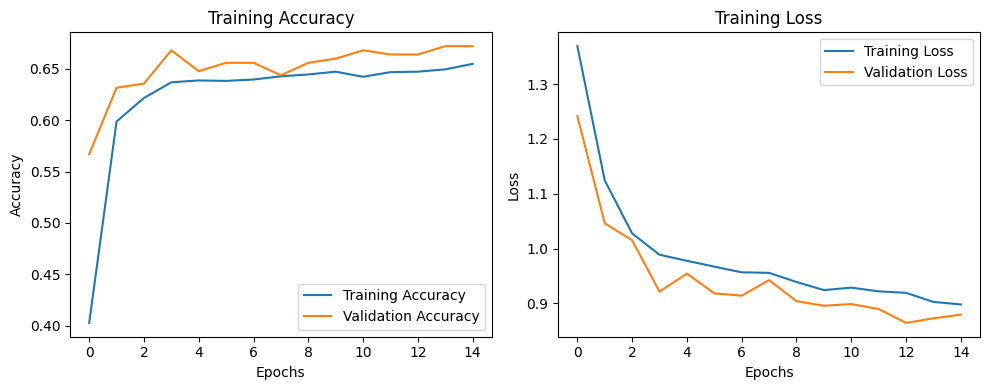

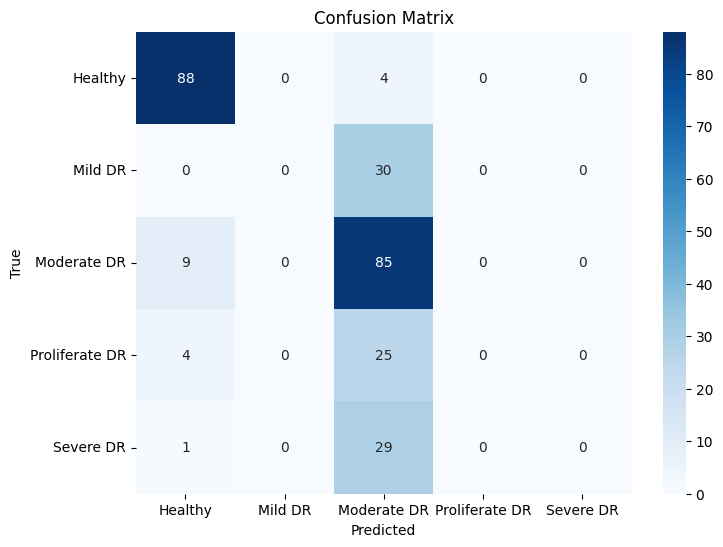

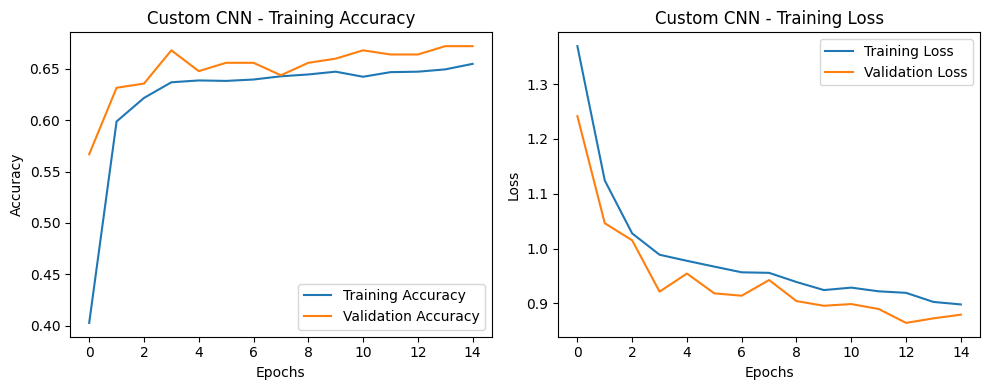

In [80]:
# Training and evaluation
for model_name, model in models:
    print(f"Training {model_name}...")
    
    history = model.fit(train_images, epochs=50, validation_data=val_images, verbose=2,callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ])
    
    # Evaluation
    evaluate_model(model, test_images)
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Training Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Training Loss')
    
    plt.tight_layout()
    plt.show()

In [ ]:
'''from tensorflow.keras.applications import DenseNet121

# Create an InceptionV3 model (you can change the input_shape and other parameters as needed)
densenet_model = DenseNet121(weights='imagenet', include_top=True)

# Print the model summary
#densenet_model.summary()'''

In [ ]:
'''from tensorflow.keras.models import Model
import tensorflow as tf'''

In [ ]:
'''def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    img = preprocess_input(img_array)
    img = tf.convert_to_tensor([img])
    
    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grads_model = Model([model.inputs], [last_conv_layer.output, model.output])

    # Get the gradients of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grads_model(img)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Calculate the weights for the feature map
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Reshape the weights to match the dimensions of the feature map
    weights = tf.reshape(weights, (1, 1, 1, -1))
    
    # Multiply the weights with the feature map
    cam = tf.reduce_sum(weights * conv_outputs, axis=-1)
    
    # Apply ReLU to the CAM
    cam = tf.maximum(cam, 0)
    
    # Normalize the CAM
    cam /= tf.math.reduce_max(cam)
    
    return cam.numpy()'''


In [ ]:
#import cv2

In [ ]:
'''# Choose a model and an image index for Grad-CAM visualization
selected_model = densenet_model  # Replace with the model you want to visualize
image_index = np.random.rand(20)  # Replace with the index of the image you want to visualize

# Get the last convolutional layer name of the selected model
if selected_model == MobileNetV2_model:
    last_conv_layer_name = "conv5_block16_concat"  # Change this to the appropriate layer name
elif selected_model == vgg_model:
    last_conv_layer_name = "block5_conv3"
elif selected_model == resnet_model:
    last_conv_layer_name = "conv5_block3_3_conv"
elif selected_model == densenet_model:
    last_conv_layer_name = "conv5_block16_2_conv"    
elif selected_model == cnn_model:
    last_conv_layer_name = "conv2d_96"    
    

for image_index in range(20):    
# Load and preprocess the image, resizing it to (224, 224) while preserving aspect ratio
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)



# Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.inception_v3.preprocess_input)

    def overlay_heatmap(image, heatmap, alpha=0.6, cmap='jet'):
        # Resize the heatmap to match the image dimensions
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

        # Apply the colormap
        color_map = plt.get_cmap(cmap)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize
        heatmap = (color_map(heatmap) * 255).astype(np.uint8)

        # Blend the heatmap and the image using cv2.addWeighted
        overlay = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 1 - alpha, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR), alpha, 0)

        return cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap)

    # Plot the original image and overlay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Grad-CAM Heatmap Overlay')
    plt.axis('off')

    plt.show()
    image_index=+1

'''

In [ ]:
#!pip install tf-explain

In [70]:
'''from tf_explain.core.grad_cam import GradCAM
import cv2

# Choose an image index for GradCAM visualization
image_index = np.random.rand(20)  # Change this to the index of the image you want to visualize

# Load the image using tf.keras
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)


# Preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

# Create GradCAM explainer
    explainer = GradCAM()

# Choose the layer for visualization (e.g., the last convolutional layer)
    layer_name = "block5_conv3"

# Explain the model's prediction
    grid = explainer.explain(validation_data=(img_array, None), model= vgg_model, class_index=0, layer_name=layer_name)

# Plot the original image and GradCAM heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grid), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title('GradCAM Heatmap')
    plt.show()
    image_index=+1
    '''

SyntaxError: incomplete input (3618317450.py, line 1)

# **gradCam for VGG**

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.5, cmap='jet'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
last_conv_layer_name = 'block5_conv3'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap)

    # Plot the original image and overlay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
    image_index=+1
'''

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.7, cmap='hot'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
last_conv_layer_name = 'block5_conv3'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Increase the alpha value for a stronger heatmap overlay
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap, alpha=0.7)

    # Plot the original image, heatmap, and overlay
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
'''

# **gradCam for MobileNet**

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.5, cmap='jet'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True)
last_conv_layer_name = 'Conv_1_bn'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap)

    # Plot the original image and overlay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
    image_index=+1
'''

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.7, cmap='hot'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True)
last_conv_layer_name = 'Conv_1_bn'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Increase the alpha value for a stronger heatmap overlay
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap, alpha=0.7)

    # Plot the original image, heatmap, and overlay
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
'''

# **gradCam for ResNet**

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.5, cmap='jet'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)
last_conv_layer_name = 'conv5_block3_3_conv'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap)

    # Plot the original image and overlay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
    image_index=+1
'''

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.7, cmap='hot'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)
last_conv_layer_name = 'conv5_block3_3_conv'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Increase the alpha value for a stronger heatmap overlay
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap, alpha=0.7)

    # Plot the original image, heatmap, and overlay
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
    '''


# **gradCam for denseNet**

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.5, cmap='jet'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=True)
last_conv_layer_name = 'conv5_block16_2_conv'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap)

    # Plot the original image and overlay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
    image_index=+1
'''

In [ ]:
'''import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define a function to generate Grad-CAM heatmap
def generate_grad_cam(model, last_conv_layer_name, img_array, preprocess_input):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Resize the input image to match the model's expected input shape
    img_array = tf.image.resize(img_array, (224, 224))

    # Preprocess the input image using the correct preprocess_input function
    img_array = preprocess_input(img_array)

    # Get the gradient of the predicted class with regard to the output feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate the gradients
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Get the convolution outputs and guided gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    # Compute the weighted average of the convolution outputs
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Apply ReLU and normalize the heatmap
    cam = tf.nn.relu(cam)
    cam /= tf.math.reduce_max(cam)

    return cam.numpy()

# Define a function to overlay the heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.7, cmap='hot'):
    # Apply a color map to the heatmap
    heatmap = (plt.get_cmap(cmap)(heatmap) * 255).astype(np.uint8)
    
    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB format
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay the heatmap on the original image using cv2.addWeighted()
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    return overlay

# Load your model and specify the last convolutional layer name
selected_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=True)
last_conv_layer_name = 'conv5_block16_2_conv'

# Load and preprocess your image
for image_index in range(20):
    image_path = image_df['Filepath'][image_index]
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(selected_model, last_conv_layer_name, img_array, tf.keras.applications.densenet.preprocess_input)

    # Increase the alpha value for a stronger heatmap overlay
    overlay = overlay_heatmap(img_array.astype(np.uint8), heatmap, alpha=0.7)

    # Plot the original image, heatmap, and overlay
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_array.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title('Heatmap Overlay')
    plt.axis('off')

    plt.show()
'''